<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/File_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<h1 align="center"><font color='#DD4141'> S4E9 Regression of Used Car Prices**</font></h1>

In [ ]:
%%capture
# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

!pip install category-encoders
!pip install optuna
!pip install optuna-integration
!pip install scikit-learn==1.4
!pip install catboost

In [ ]:
folder_script = models_folders = "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S4E9_Cars"
os.chdir(folder_script)

In [ ]:
# Setup feedback system
#from learntools.core import binder
#binder.bind(globals())
#from learntools.time_series.ex6 import *

# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
import datetime
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  ARDRegression,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')

<Figure size 960x660 with 0 Axes>

In [ ]:
import xgboost
print(xgboost.__version__)
print(sklearn.__version__)

2.1.1
1.4.0


In [ ]:
%%time
#import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import logging
import warnings

# Setting rc parameters in seaborn for plots and graphs-
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 1.82 ms


<Figure size 960x660 with 0 Axes>

In [ ]:
def plot_categorical_columns(df):
    # Select only categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Loop through each categorical column and plot
    for col in categorical_columns:
        if len(set(df[col]))<150:
            plt.figure(figsize=(6, 4))
            sns.countplot(y=df[col], palette=palette_9, order=df[col].value_counts().index)
            plt.title(f'Distribution of {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()

In [ ]:
#plot_categorical_columns(df_train)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

**<h3 align="center"><font color='#3455eb'> Used Cars Regression :</font></h3>**

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#3455eb'> About The Competition :</font></h3>
    
**Task**: To develop a model that can predict the prices of used cars based on a set of parameters relative to the cars. It is a **regression task**.

**Dataset**: Training Dataset (train.csv): Contains features along with the target variable, indicating the car price.Test Dataset (test.csv): Contains the features but requires predictions for the price.

Additional Information:
    
**Evaluation**: The performance of the model is evaluated using the RMSE. This metric penalizes the outliers prices.

The dataset was generated from a deep learning model trained on the Used Car Price Prediction [Link]().

### Importing Libraries

In [ ]:
df_sub=pd.read_csv("sample_submission.csv",na_values=["–", "not supported"])
df_train=pd.read_csv("train.csv",na_values=["–", "not supported"])
df_test=pd.read_csv("test.csv",na_values=["–", "not supported"])


df_old=pd.read_csv("used_cars.csv",na_values=["–", "not supported"])

In [ ]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
df_old[['milage', 'price']] = df_old[['milage', 'price']].map(lambda x: int(''.join(re.findall(r'\d+', x))))
df_old[['milage', 'price']] = df_old[['milage', 'price']].astype(int)

In [ ]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   int64 
 4   fuel_type     3792 non-null   object
 5   engine        3964 non-null   object
 6   transmission  4005 non-null   object
 7   ext_col       3994 non-null   object
 8   int_col       3876 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 376.0+ KB


In [ ]:
print("Shape Train: {}\nShape Test: {}\nShape Old: {}\n".format(df_train.shape,df_test.shape,df_old.shape))

Shape Train: (188533, 13)
Shape Test: (125690, 12)
Shape Old: (4009, 12)



In [ ]:
re_ = ['model','engine','transmission','ext_col','int_col']
t=100
col='model'
df_train.loc[df_train[col].value_counts(dropna=False)[df_train[col]].values < t, col]

,model
1,LS V8
2,Silverado 2500 LT
3,G90 5.0 Ultimate
5,A6 2.0T Sport
6,A8 L 3.0T
...,...
188516,M37 x
188517,Navigator L Select
188518,S-Class S 450 4MATIC
188521,M240 i xDrive


In [ ]:
df_train.brand.unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota',
       'Hyundai', 'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM',
       'Hummer', 'Alfa', 'INFINITI', 'Jeep', 'Porsche', 'McLaren',
       'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia',
       'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn',
       'Bentley', 'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini',
       'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma',
       'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury',
       'Polestar', 'Maybach'], dtype=object)

In [ ]:
df_train[df_train["brand"]=="Ferrari"]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
251,251,Ferrari,911 GT2 RS,2022,19250,Gasoline,710.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Orange,Red,None reported,Yes,124900
433,433,Ferrari,F12berlinetta Base,2017,25520,Gasoline,6.3L V12 48V GDI DOHC,7-Speed Automatic with Auto-Shift,Gray,BLACK,None reported,NaN,449995
1554,1554,Ferrari,F12berlinetta Base,2018,28220,Gasoline,759.0HP 6.5L 12 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,White,None reported,Yes,37400
1784,1784,Ferrari,812 Superfast Base,2018,7960,Gasoline,788.0HP 6.5L 12 Cylinder Engine Gasoline Fuel,8-Speed A/T,Red,Beige,None reported,Yes,125900
3146,3146,Ferrari,488 GTB Base,2018,17761,Gasoline,4.0L V8 32V GDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,Rosso Corsa,Black,None reported,NaN,229900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184666,184666,Ferrari,Roma Base,2021,3000,Gasoline,611.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Brown,None reported,Yes,215000
184690,184690,Ferrari,Roma Base,2020,19500,Gasoline,611.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Green,NaN,None reported,Yes,89000
185350,185350,Ferrari,M6 Base,2015,25500,Gasoline,560.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes,51950
185697,185697,Ferrari,488 Spider Base,2016,117000,Gasoline,660.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,21000


**There is an error in the Ferrari data. The 911 GT2 is a Porsche Model and not a Ferrari. For each model there can be only one corresonding automaker.**

In [ ]:
df_concat = pd.concat([df_train, df_test], axis=0)

df_concat.groupby("model")["brand"].value_counts()

model                  brand     
124 Spider Abarth      FIAT           9
                       BMW            1
128 i                  BMW           27
                       Chrysler       1
                       FIAT           1
                                     ..
tC Base                Volkswagen     1
tC Release Series 6.0  Scion         32
                       Toyota         2
xB Base                Scion         15
                       BMW            1
Name: count, Length: 4413, dtype: int64

In [ ]:
df_old.groupby("model")["brand"].value_counts()

,,count
model,brand,
124 Spider Abarth,FIAT,1
128 i,BMW,1
135 i,BMW,3
135 is,BMW,1
1500 Big Horn,RAM,11
...,...,...
i8 Base,BMW,5
tC Anniversary Edition,Scion,2
tC Base,Scion,1


In [ ]:
# Group by 'model' and count the occurrences of each 'brand'
brand_counts = df_concat.groupby('model')['brand'].value_counts().rename('count').reset_index()

# Find the most frequent brand for each model
most_frequent_brand = brand_counts.sort_values(['model', 'count'], ascending=False).groupby('model').head(1)

# Create a dictionary mapping 'model' to the most frequent 'brand'
brand_map = most_frequent_brand.set_index('model')['brand'].to_dict()

# Replace the 'brand' in the original DataFrame based on the 'model' and the brand_map
df_train['brand'] = df_train['model'].map(brand_map).values
df_test['brand'] = df_test['model'].map(brand_map).values

In [ ]:
df_train.groupby("model")["brand"].value_counts()

,,count
model,brand,
124 Spider Abarth,FIAT,5
128 i,BMW,21
135 i,BMW,122
135 is,BMW,14
1500 Big Horn,RAM,660
...,...,...
i8 Base,BMW,60
tC Anniversary Edition,Scion,38
tC Base,Scion,15


In [ ]:
df_train[df_train.fuel_type=="not supported"]#.isna().sum()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price


In [ ]:
df_train.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5879
engine,925
transmission,87
ext_col,366
int_col,4527


In [ ]:
df_test.isnull().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,3935
engine,617
transmission,40
ext_col,223
int_col,2953


## EDA:

### **FUNCTIONS**

In [ ]:
def extract_fuel_type(engine_desc):
    """Extracts fuel type from engine description using regex."""

    fuel_patterns = {
        'Gasoline': r'(?i)gasoline',
        'Diesel': r'(?i)diesel',
        'Electric': r'(?i)electric',
        'E85 Flex Fuel': r'(?i)flex fuel',
        'Hybrid': r'(?i)hybrid'
    }

    for fuel_type, pattern in fuel_patterns.items():
        if re.search(pattern, engine_desc):
            return fuel_type

    return np.nan

# Function to fill missing 'engine' values based on 'brand' and 'model'
def fill_engine(row):
  """Function to fill missing 'engine' values based on 'brand' and 'model'"""

  if pd.isnull(row['engine']):
      return engine_map.get((row['brand'], row['model']))
  else:
      return row['engine']

# Function to impute missing 'transmission' values
def impute_transmission(row):
    if pd.isnull(row['transmission']):
        return mode_transmission_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['transmission']


def extract_engine_features(engine_str):
    """Extracts engine features from the engine string using regex."""

    # Horsepower
    horsepower_match = re.search(r'(\d+\.?\d*)HP', engine_str)
    horsepower = float(horsepower_match.group(1)) if horsepower_match else None

    # Engine Capacity
    capacity_match = re.search(r'(\d+\.?\d*)L', engine_str)
    engine_capacity = float(capacity_match.group(1)) if capacity_match else None

    # Engine Capacity (Modified)
    capacity_match_mod = re.search(r'(\d+\.?\d*)(?: |-)L(?:iter)?', engine_str)
    engine_capacity_mod = float(capacity_match_mod.group(1)) if capacity_match_mod else engine_capacity

    # Turbo
    turbo = 'Turbo' if 'turbo' in engine_str.lower() else 'No Turbo'

    return pd.Series({'horsepower': horsepower, 'engine_capacity': engine_capacity_mod, 'turbo': turbo})

def extract_num_cylinders(engine_str):
    """Extracts the number of cylinders from an engine string."""

    cylinder_match = re.search(r'(H|I|V|W)?(\d+)(?: |-)Cylinder|(H|I|V|W)(\d+)', engine_str)
    if cylinder_match:
        if cylinder_match.group(2) is not None:  # I, V, or W configuration with explicit "Cylinder"
            return int(cylinder_match.group(2))
        else:  # V or W configuration without "Cylinder"
            return int(cylinder_match.group(4))
    else:
        return None

# Function 1 to impute missing 'horsepower' values
def impute_horsepower_step_1(row):
    if pd.isnull(row['horsepower']):
        return median_horsepower_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['horsepower']

# Function 2 to impute missing 'horsepower' values
def impute_horsepower_step_2(row):
    if pd.isnull(row['horsepower']):
        return median_horsepower_by_brand.get((row['brand']))
    else:
        return row['horsepower']

# Function 3 to impute missing 'horsepower' values
def impute_horsepower_step_3(row):
    if pd.isnull(row['horsepower']):
      if row['num_cylinders'] == 8:
        return 600
      elif row['num_cylinders'] == 12:
        return 850
      elif row['num_cylinders'] == 16:
        return 1000
    else:
        return row['horsepower']


# Function to impute missing 'transmission' values
def impute_capacity_1(row):
    if pd.isnull(row['engine_capacity']):
        return median_capacity_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['engine_capacity']

# Function to impute missing 'capacity' values
def impute_capacity_2(row):
    if pd.isnull(row['engine_capacity']):
        return median_capacity_by_brand.get(row['brand'])
    else:
        return row['engine_capacity']

# Function to impute missing 'cylinder' values
def impute_cyl_1(row):
    if pd.isnull(row['num_cylinders']):
        return median_num_cylinders_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['num_cylinders']

# Function to impute missing 'capacity' values
def impute_cyl_2(row):
    if pd.isnull(row['num_cylinders']):
        return median_num_cylinders_by_brand.get(row['brand'])
    else:
        return row['num_cylinders']

In [ ]:
df_train.fillna("Missing", inplace=True)
df_train.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [ ]:
df_train_ = df_train.copy()
df_train_["train"]=1
df_test_ = df_test.copy()
df_test_["train"]=0
df_total = pd.concat([df_train_,df_test_])

unique_cars = df_total.groupby(["brand","model","engine","transmission","model_year","milage","accident"], as_index=False)[["price","train"]].agg({"price":"mean","train":"count","train":["count","sum"]})#.sort_values("price",ascending=True)
unique_cars_to_merge = unique_cars[(unique_cars.loc[:,("train","count")]==2)&(unique_cars.loc[:,("train","sum")]==1)]#.tail(100)
unique_cars_to_merge.drop(columns=["train"],inplace=True)
unique_cars_to_merge.columns = [''.join(col) if isinstance(col, tuple) else col for col in unique_cars_to_merge.columns]
unique_cars_to_merge#.drop(labels="mean",level=1,axis=1)
#unique_cars.groupby("count")[["mean","std"]].mean().sort_values("mean",ascending=False)

df_test_meged = df_test.merge(unique_cars_to_merge,on=["brand","model","engine","transmission","model_year","milage","accident"],how="left")
test_to_replace = df_test_meged[df_test_meged.pricemean.isna()==False][["id","pricemean"]]
test_to_replace#.max()#.set_index("id")#

,id,pricemean
50,188583,98000.0
124,188657,42000.0
141,188674,9500.0
155,188688,43000.0
166,188699,55000.0
...,...,...
125640,314173,66900.0
125668,314201,49000.0
125676,314209,75000.0
125677,314210,42500.0


In [ ]:
df_best_sub.loc[df_best_sub.id==314214]

,id,price
125681,314214,60770.491215


In [ ]:
df_best_sub = pd.read_csv("submissions/submission_ensemble_v0.csv")
print(df_best_sub.shape)
print(df_best_sub[df_best_sub.id==188583])
for idx in tqdm(test_to_replace.id):
    df_best_sub.loc[df_best_sub.id==idx,"price"] = test_to_replace[test_to_replace.id==idx]["pricemean"].values
print(df_best_sub[df_best_sub.id==188583])

(125690, 2)
        id         price
50  188583  93975.427433


100%|██████████| 5135/5135 [00:04<00:00, 1193.09it/s]

        id    price
50  188583  98000.0


In [ ]:
df_best_sub.shape

(125690, 2)

In [ ]:
df_best_sub.to_csv("submissions/submission_ensemble_v0_1.csv", index=False)

In [ ]:
# Group by 'brand' and 'model', count occurrences of 'engine', and find the most frequent
engine_counts = df_train.groupby(['brand', 'model'])['engine'].value_counts().rename('count').reset_index()
most_frequent_engine = engine_counts.sort_values(['brand', 'model', 'count'], ascending=False).groupby(['brand', 'model']).head(1)

# Create a dictionary mapping ('brand', 'model') tuples to the most frequent 'engine'
engine_map = most_frequent_engine.set_index(['brand', 'model'])['engine'].to_dict()

In [ ]:
# Apply the function to fill missing values in 'engine'
df_train['engine'] = df_train.apply(fill_engine, axis=1)
df_test['engine'] = df_test.apply(fill_engine, axis=1)

# Apply the function to fill missing values in 'engine'
df_train['engine'] = df_train.apply(fill_engine, axis=1)
df_test['engine'] = df_test.apply(fill_engine, axis=1)

# Apply the function fillna'
df_train['engine'] = df_train['engine'].fillna("Missing", axis=0)
df_test['engine'] = df_test['engine'].fillna("Missing", axis=0)

# Print the count of missing values in 'engine'
print(f"Missing values in 'engine' after filling: {df_train['engine'].isnull().sum()}")
print(f"Missing values in 'engine' after filling: {df_test['engine'].isnull().sum()}")

Missing values in 'engine' after filling: 0
Missing values in 'engine' after filling: 0


In [ ]:
df_train[df_train['engine'].isna()==True]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price


In [ ]:
df_test[df_test['engine'].isna()==True]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title


In [ ]:
df_old[df_old['model']=="Capri XR2"]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
1805,Mercury,Capri XR2,1993,120644,NaN,NaN,5-Speed M/T,Green,Gray,None reported,Yes,4200


### **Replacing NaNs: Fuel Type**

The type of fuel is usually embed into the engine specification, for instance "48.0HP 2.0L 4 Cylinder Engine Gasoline Fuel".

This information is extracted for the engine feature where available.

In [ ]:
df_train.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid'], dtype=object)

In [ ]:
df_test.fuel_type.unique()

array(['Gasoline', 'Hybrid', 'Diesel', 'E85 Flex Fuel', nan,
       'Plug-In Hybrid'], dtype=object)

In [ ]:
# Apply the function to create a new column
df_train['extracted_fuel'] = df_train['engine'].astype(str).apply(extract_fuel_type)
df_test['extracted_fuel'] = df_test['engine'].astype(str).apply(extract_fuel_type)

# Fill missing values in 'fuel_type' with values from 'extracted_fuel'
df_train['fuel_type'] = df_train['fuel_type'].fillna(df_train['extracted_fuel'])
df_test['fuel_type'] = df_test['fuel_type'].fillna(df_test['extracted_fuel'])

# Drop the temporary column
df_train.drop('extracted_fuel', axis=1, inplace=True)
df_test.drop('extracted_fuel', axis=1, inplace=True)

# If no info is available, the entry is populated with "Gasoline" 'extracted_fuel'
df_train['fuel_type'] = df_train['fuel_type'].fillna("Gasoline")
df_test['fuel_type'] = df_test['fuel_type'].fillna("Gasoline")

# Print the count of missing values in 'fuel_type'
print(f"Missing values in 'fuel_type' after filling: {df_train['fuel_type'].isnull().sum()}")
print(f"Missing values in 'fuel_type' after filling: {df_test['fuel_type'].isnull().sum()}")

Missing values in 'fuel_type' after filling: 0
Missing values in 'fuel_type' after filling: 0


In [ ]:
df_train.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electric', 'Hybrid', 'Diesel',
       'Plug-In Hybrid'], dtype=object)

In [ ]:
# Filter rows where brand is 'Tesla' and fuel_type is 'Gasoline'
tesla_gasoline_rows = df_train[(df_train['brand'] == 'Tesla') & (df_train['fuel_type'] == 'Gasoline')]
tesla_gasoline_rows_test = df_test[(df_test['brand'] == 'Tesla') & (df_test['fuel_type'] == 'Gasoline')]

# Update 'fuel_type' to 'Electric' for these rows
df_train.loc[tesla_gasoline_rows.index, 'fuel_type'] = 'Electric'
df_test.loc[tesla_gasoline_rows_test.index, 'fuel_type'] = 'Electric'

# Filter again to check if any 'Tesla' cars still have 'Gasoline' as fuel_type
remaining_tesla_gasoline_rows = df_train[(df_train['brand'] == 'Tesla') & (df_train['fuel_type'] == 'Gasoline')]
remaining_tesla_gasoline_rows_test = df_test[(df_test['brand'] == 'Tesla') & (df_test['fuel_type'] == 'Gasoline')]

# Print the number of remaining rows
print(f"Number of Tesla cars with 'Gasoline' as fuel_type after correction - Train: {len(remaining_tesla_gasoline_rows)}")
print(f"Number of Tesla cars with 'Gasoline' as fuel_type after correction - Train: {len(remaining_tesla_gasoline_rows_test)}")

Number of Tesla cars with 'Gasoline' as fuel_type after correction - Train: 0
Number of Tesla cars with 'Gasoline' as fuel_type after correction - Train: 0


**Conclusion**: total number of missing values has been reduced from 5879 to 951.

### **Replacing NaN: Transmission"**

In [ ]:
# Group by 'brand' and 'model', compute the mode of 'transmission'
mode_transmission_by_brand_model = df_train.groupby(['brand', 'model'])['transmission'].agg( lambda x: pd.Series.mode(x)[0] ).to_dict()

# Apply the function to fill missing values
df_train['transmission'] = df_train.apply(impute_transmission, axis=1)
df_test['transmission'] = df_test.apply(impute_transmission, axis=1)

# Count the number of missing values in 'transmission' after imputation
missing_transmission_after = df_train['transmission'].isnull().sum()
missing_transmission_after_test = df_test['transmission'].isnull().sum()

print(f"Missing values in 'transmission' after filling (train): {missing_transmission_after}")
print(f"Missing values in 'transmission' after filling (test): {missing_transmission_after_test}")

Missing values in 'transmission' after filling (train): 0
Missing values in 'transmission' after filling (test): 0


In [ ]:
df_total = pd.concat([df_train, df_test])
df_total.transmission.unique()
{a:"" for a in df_total.transmission.unique()}

df_total[df_total.transmission=="SCHEDULED FOR OR IN PRODUCTION"]#.head(3) #ESTRACT TURBO

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
15137,15137,BMW,M440 i xDrive,2021,61145,Hybrid,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Alpine White,Black,None reported,NaN,83598.0
24481,24481,Audi,Q5 2.0T Premium Plus,2019,36486,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,SCHEDULED FOR OR IN PRODUCTION,Gray,Red,None reported,Yes,23750.0
74979,74979,BMW,M240 i,2021,13177,Gasoline,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Brilliant Silver Metallic,Black,None reported,NaN,72598.0
76188,76188,BMW,M3 CS,2022,26609,Gasoline,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Mythos Black Metallic,White,None reported,NaN,35645.0
115301,115301,BMW,X6 xDrive40i,2020,28567,Gasoline,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Carbon Black Metallic,Black,At least 1 accident or damage reported,NaN,54998.0
136829,136829,BMW,530 i xDrive,2019,48156,Hybrid,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Glacier Silver Metallic,Canberra Beige/Black,None reported,NaN,31698.0
35202,223735,BMW,X3 xDrive30i,2021,2492,Gasoline,2.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Black Sapphire Metallic,Canberra Beige,None reported,NaN,NaN
41876,230409,BMW,840 Gran Coupe i xDrive,2020,23647,Gasoline,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Black Sapphire Metallic,Black,None reported,NaN,NaN
42696,231229,Mercedes-Benz,GLE 350 Base 4MATIC,2022,94101,Gasoline,2.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Black,Silk Beige/Espresso Brown,None reported,NaN,NaN
48605,237138,Audi,Q8 3.0T Prestige,2019,25348,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,SCHEDULED FOR OR IN PRODUCTION,Black Sapphire Metallic,Black,At least 1 accident or damage reported,Yes,NaN


In [ ]:
df_train_shift = df_train.copy()
df_train["shift_dummy"] = df_train['transmission'].str.contains('Shift&6|8|9|10', case=False).astype(int)

df_train.groupby("shift_dummy")["price"].agg(["mean","count","std"])

,mean,count,std
shift_dummy,,,
0,38077.149279,141386,70860.478924
1,61273.849789,47147,96859.196633


In [ ]:
# Create a color mapping dictionary (You'll likely need to expand this)
trans_map = {'A/T': 'A/T',
              'Transmission w/Dual Shift Mode': 'Dual Shift Mode',
              '7-Speed A/T': '7-Speed A/T',
              '8-Speed A/T': '8-Speed A/T',
              '10-Speed Automatic': '10-Speed A/T',
              '1-Speed A/T': '1-Speed A/T',
              '6-Speed A/T': '6-Speed A/T',
              '10-Speed A/T': '10-Speed A/T',
              '9-Speed A/T': '9-Speed A/T',
              '8-Speed Automatic': '8-Speed A/T',
              '9-Speed Automatic': '9-Speed A/T',
              '5-Speed A/T': '5-Speed A/T',
              'Automatic': 'A/T',
              '7-Speed Automatic with Auto-Shift': '7-Speed A/T',
              'CVT Transmission': 'CVT',
              '5-Speed M/T': '5-Speed M/T',
              'M/T': 'M/T',
              '6-Speed M/T': '6-Speed M/T',
              '6-Speed Automatic': '6-Speed A/T',
              '4-Speed Automatic': '4-Speed A/T',
              '7-Speed M/T': 'M/T',
              '2-Speed A/T': '1-Speed A/T',
              '1-Speed Automatic': '1-Speed A/T',
              'Automatic CVT': 'CVT',
              '4-Speed A/T': '4-Speed A/T',
              '6-Speed Manual': '6-Speed M/T',
              'Transmission Overdrive Switch': 'A/T',
              '8-Speed Automatic with Auto-Shift': '8-Speed A/T',
              '7-Speed Manual': 'M/T',
              '7-Speed Automatic': '7-Speed A/T',
              '9-Speed Automatic with Auto-Shift': '9-Speed A/T',
              '6-Speed Automatic with Auto-Shift': '6-Speed A/T',
              '6-Speed Electronically Controlled Automatic with O': '6-Speed A/T',
              'F': 'M/T',
              'CVT-F': 'CVT',
              '8-Speed Manual': 'M/T',
              'Manual': 'M/T',
              '2': '1-Speed A/T',
              '6 Speed At/Mt': '6-Speed A/T',
              '5-Speed Automatic': '5-Speed A/T',
              '2-Speed Automatic': '1-Speed A/T',
              '8-SPEED A/T': '8-Speed A/T',
              '7-Speed': 'M/T',
              'Variable': 'CVT',
              'Single-Speed Fixed Gear': '1-Speed A/T',
              '8-SPEED AT': '8-Speed A/T',
              '10-Speed Automatic with Overdrive': '10-Speed A/T',
              '7-Speed DCT Automatic': '7-Speed A/T',
              'SCHEDULED FOR OR IN PRODUCTION': 'A/T',
              '6-Speed': '6-Speed M/T',
              '6 Speed Mt': '6-Speed M/T'}

# Function to map exotic gear to base gearbox
def map_to_base_gear(gear):
    return trans_map.get(gear, gear)  # If not found in map, keep the original color

# Apply the mapping to 'ext_col'
df_train['transmission'] = df_train['transmission'].astype(str).apply(map_to_base_gear)
df_test['transmission'] = df_test['transmission'].astype(str).apply(map_to_base_gear)

# Display the updated unique values in 'ext_col'
print("\nUnique values in 'transmission' after mapping - Train:\n", df_test['transmission'].unique())
print("\nUnique values in 'transmission' after mapping - Test:\n", df_train['transmission'].unique())


Unique values in 'transmission' after mapping - Train:
 ['6-Speed A/T' '8-Speed A/T' '10-Speed A/T' 'A/T' 'Dual Shift Mode'
 '7-Speed A/T' '5-Speed M/T' '9-Speed A/T' '5-Speed A/T' 'CVT'
 '6-Speed M/T' 'M/T' '1-Speed A/T' '4-Speed A/T']

Unique values in 'transmission' after mapping - Test:
 ['A/T' 'Dual Shift Mode' '7-Speed A/T' '8-Speed A/T' '10-Speed A/T'
 '1-Speed A/T' '6-Speed A/T' '9-Speed A/T' '5-Speed A/T' 'CVT'
 '5-Speed M/T' 'M/T' '6-Speed M/T' '4-Speed A/T']


In [ ]:
set(df_train['transmission'].unique()) - set(df_test['transmission'].unique())

set()

In [ ]:
#plot_categorical_columns(df_train)

### **Replacing NaN: ext_col**

In [ ]:
df_train["ext_col_nan"] = df_train.ext_col.isna().astype(int)
df_test["ext_col_nan"] = df_test.ext_col.isna().astype(int)

#df_train[(df_train.ext_col.isna()==True)|(df_train.ext_col=="nan")]

##### **BLACK**

In [ ]:
df_train_black = df_train.copy()
df_test_black = df_test.copy()

df_train_black["ext_col"] = df_train_black["ext_col"].replace({"NaN":np.nan})
df_train_black["ext_col"] = df_train_black["ext_col"].fillna("Custom")
df_test_black["ext_col"] = df_test_black["ext_col"].replace({"NaN":np.nan})
df_test_black["ext_col"] = df_test_black["ext_col"].fillna("Custom")


df_train_black["Dummy_blk"] = df_train_black['ext_col'].str.contains('Black', case=True).astype(int)
df_train_black["Dummy_BLK"] = df_train_black['ext_col'].str.contains('BLACK', case=True).astype(int)
df_train_black["Dummy_noir"] = df_train_black['ext_col'].str.contains('Noir', case=True).astype(int)
df_train_black["Dummy_Nero"] = df_train_black['ext_col'].str.contains('Nero', case=True).astype(int)
df_test_black["Dummy_blk"] = df_test_black['ext_col'].str.contains('Black', case=True).astype(int)
df_test_black["Dummy_BLK"] = df_test_black['ext_col'].str.contains('BLACK', case=True).astype(int)
df_test_black["Dummy_noir"] = df_test_black['ext_col'].str.contains('Noir', case=True).astype(int)
df_test_black["Dummy_Nero"] = df_test_black['ext_col'].str.contains('Nero', case=True).astype(int)

display(df_train_black.groupby("Dummy_blk")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_noir")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_Nero")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_BLK")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_blk,,,,,,,
0,43654.016785,30500.0,78501.055414,20.378218,2954083,2000,134645
1,44437.702902,31000.0,79607.655921,20.003353,2954083,2000,53888


,mean,median,std,skew,max,min,count
Dummy_noir,,,,,,,
0,43878.921318,30798.0,78835.125670,20.264874,2954083,2000,188454
1,41718.810127,39853.0,18548.354054,0.954481,96850,11970,79


,mean,median,std,skew,max,min,count
Dummy_Nero,,,,,,,
0,43834.921900,30798.0,78658.367359,20.319367,2954083,2000,188476
1,186373.403509,119900.0,266577.629528,5.500463,1950995,15998,57


,mean,median,std,skew,max,min,count
Dummy_BLK,,,,,,,
0,43870.678861,30798.0,78815.704123,20.274058,2954083,2000,188504
1,91571.586207,53998.0,90166.889782,1.697641,359991,3995,29


In [ ]:
df_train = pd.concat([df_train,df_train_black[["Dummy_Nero","Dummy_BLK"]]],axis=1)
df_test = pd.concat([df_test,df_test_black[["Dummy_Nero","Dummy_BLK"]]],axis=1)
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,0


##### **SPECIAL COLORS**

In [ ]:
list_special_colors = list(df_train_black.groupby("ext_col")["price"].agg(["mean","median","std","skew","max","min","count"]).sort_values("mean",ascending=False).head(15).index)

df_train_black["Dummy_Special_color"] = df_train_black['ext_col'].isin(list_special_colors).astype(int)
df_test_black["Dummy_Special_color"] = df_test_black['ext_col'].isin(list_special_colors).astype(int)

In [ ]:
display(df_train_black.groupby("Dummy_Special_color")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_Special_color,,,,,,,
0,43412.356475,30510.0,76422.944641,20.622603,2954083,2000,188061
1,229412.824153,173995.0,346690.862539,5.479813,2954083,8450,472


In [ ]:
list_poor_colors = list(df_train_black.groupby("ext_col")["price"].agg(["mean","median","std","skew","max","min","count"]).sort_values("mean",ascending=False).tail(15).index)
list_poor_colors.remove("Beige")
list_poor_colors.remove("Gold")

df_train_black["Dummy_Poor_color"] = df_train_black['ext_col'].isin(list_poor_colors).astype(int)
df_test_black["Dummy_Poor_color"] = df_test_black['ext_col'].isin(list_poor_colors).astype(int)

In [ ]:
display(df_train_black.groupby("Dummy_Poor_color")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_Poor_color,,,,,,,
0,43914.263759,30890.0,78915.969456,20.245503,2954083,2000,188043
1,29967.600000,28324.0,13442.365456,2.005795,134999,3995,490


In [ ]:
df_train = pd.concat([df_train,df_train_black[["Dummy_Special_color","Dummy_Poor_color"]]],axis=1)
df_test = pd.concat([df_test,df_test_black[["Dummy_Special_color","Dummy_Poor_color"]]],axis=1)
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,0,0,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,0,0,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,0,0,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,0,0,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,0,0,0


##### **RED**

In [ ]:
df_train_black["Dummy_red"] = df_train_black['ext_col'].str.contains('Red', case=True).astype(int)
df_train_black["Dummy_RED"] = df_train_black['ext_col'].str.contains('Rosso', case=True).astype(int)
df_test_black["Dummy_red"] = df_test_black['ext_col'].str.contains('Red', case=True).astype(int)
df_test_black["Dummy_RED"] = df_test_black['ext_col'].str.contains('Rosso', case=True).astype(int)

display(df_train_black.groupby("Dummy_red")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_RED")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_red,,,,,,,
0,44027.173334,30999.0,78781.705433,20.298191,2954083,2000,176763
1,41637.959558,28450.0,79354.944067,19.859356,2954083,2000,11770


,mean,median,std,skew,max,min,count
Dummy_RED,,,,,,,
0,43760.943741,30775.0,78686.514752,20.382135,2954083,2000,188308
1,141858.800000,89750.0,119150.964831,1.363687,749950,9499,225


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_RED"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_RED"]],axis=1)
#df_train.head()

##### **Blue**

In [ ]:
df_train_black["Dummy_blue"] = df_train_black['ext_col'].isin(["blue","Blue"]).astype(int).astype(int)
df_train_black["Dummy_BLUE"] = df_train_black['ext_col'].isin(["BLUE","Blu"]).astype(int).astype(int)
df_test_black["Dummy_blue"] = df_test_black['ext_col'].isin(["blue","Blue"]).astype(int)
df_test_black["Dummy_BLUE"] = df_test_black['ext_col'].isin(["BLUE","Blu"]).astype(int)

display(df_train_black.groupby("Dummy_blue")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_BLUE")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_blue,,,,,,,
0,44147.347624,30900.0,79708.504328,20.151263,2954083,2000,173978
1,40658.658811,30000.0,67209.124007,21.602932,2954083,2000,14555


,mean,median,std,skew,max,min,count
Dummy_BLUE,,,,,,,
0,43852.753567,30798.0,78816.405101,20.282953,2954083,2000,188408
1,81955.440000,54900.0,74475.947147,2.542191,491836,5899,125


In [ ]:
#df_train = pd.concat([df_train,df_train_black["Dummy_BLUE"]],axis=1)
#df_test = pd.concat([df_test,df_test_black["Dummy_BLUE"]],axis=1)

In [ ]:
#df_train.head(3)

##### **Multiple Colors**

In [ ]:
df_train_black["Dummy_mult"] = df_train_black['ext_col'].str.contains("/ B|w/", case=True).astype(int)
df_test_black["Dummy_mult"] = df_test_black['ext_col'].str.contains("/", case=True).astype(int)

display(df_train_black.groupby("Dummy_mult")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_mult,,,,,,,
0,43844.261359,30775.0,78803.099323,20.292378,2954083,2000,188404
1,93176.798450,59980.0,87293.825782,2.406960,491836,6348,129


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_mult"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_mult"]],axis=1)

##### **Gray/Grey**

In [ ]:
df_train_black["Dummy_grey"] = df_train_black['ext_col'].str.contains("Grey|Grigio|SILVER", case=True).astype(int)
df_test_black["Dummy_grey"] = df_test_black['ext_col'].str.contains("Grey|Grigio|SILVER", case=True).astype(int)

display(df_train_black.groupby("Dummy_grey")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_grey,,,,,,,
0,43773.509622,30599.0,78598.866381,20.384497,2954083,2000,188112
1,90573.828979,50998.0,139978.873248,7.312155,1950995,6099,421


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_grey"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_grey"]],axis=1)

##### **METALLIC**

In [ ]:
df_train_black["Dummy_metal"] = df_train_black['ext_col'].str.contains("Metallic", case=True).astype(int)
df_test_black["Dummy_metal"] = df_test_black['ext_col'].str.contains("Metallic", case=True).astype(int)

display(df_train_black.groupby("Dummy_metal")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_metal,,,,,,,
0,43076.843725,29999.0,78166.660946,20.565665,2954083,2000,180016
1,60811.661853,42598.0,89885.370324,16.514956,2954083,2899,8517


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_metal"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_metal"]],axis=1)

##### **PEARL**

In [ ]:
df_train_black["Dummy_pearl"] = df_train_black['ext_col'].str.contains("pearl", case=False).astype(int)
df_test_black["Dummy_pearl"] = df_test_black['ext_col'].str.contains("pearl", case=False).astype(int)

display(df_train_black.groupby("Dummy_pearl")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_pearl,,,,,,,
0,43729.012384,30500.0,78595.012686,20.314105,2954083,2000,186292
1,56264.546631,39985.0,94863.647201,17.601045,2954083,3200,2241


##### **TintCoat**

In [ ]:
df_train_black["Dummy_tin"] = df_train_black['ext_col'].str.contains("tintcoat", case=False).astype(int)
df_test_black["Dummy_tin"] = df_test_black['ext_col'].str.contains("tintcoat", case=False).astype(int)

display(df_train_black.groupby("Dummy_tin")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_tin,,,,,,,
0,43866.313494,30775.0,78858.722022,20.268367,2954083,2000,188243
1,51474.389655,41549.5,46368.289478,4.338081,399900,3499,290


##### **Custom**

In [ ]:
df_train_black["Dummy_cus"] = df_train_black['ext_col'].str.contains("custom", case=False).astype(int)
df_test_black["Dummy_cus"] = df_test_black['ext_col'].str.contains("custom", case=False).astype(int)

display(df_train_black.groupby("Dummy_cus")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_cus,,,,,,,
0,43676.873411,30599.0,78355.653525,20.518503,2954083,2000,188144
1,141162.861183,79998.0,179091.927876,4.830084,1950995,3850,389


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_cus"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_cus"]],axis=1)

##### **Replace NAN**

In [ ]:
# Create a color mapping dictionary (You'll likely need to expand this)
color_map = {
    'Soul Red Crystal Metallic': 'Red',
    'nan':np.nan,
    'Ruby Red Metallic Tinted Clearcoat': 'Red',
    'Rosso Corsa': 'Red',
    'verde': 'Green',
    'Snowflake White Pearl Metallic': 'White',
    'Gray' : 'Grey',
    'Santorini Black Metallic' : 'Black',
    'Ebony Twilight Metallic' : 'Black',
    'Magnetite Black Metallic' : 'Black',
    'Diamond Black' : 'Black',
    'Vega Blue' : 'Blue',
    'Beige': 'Beige',
     'Gold': 'Yellow',
     'Platinum White Pearl': 'White',
     'Metallic': 'Grey',
     'White Frost Tri-Coat': 'White',
     'Firecracker Red Clearcoat': 'Red',
     'Phytonic Blue Metallic': 'Blue',
     'Blu': 'Blue',
     'Orange': 'Orange',
     'Brown': 'Beige',
     'Brilliant Silver Metallic': 'Grey',
     'Black Raven': 'Black',
     'Black Clearcoat': 'Black',
     'Firenze Red': 'Red',
     'Agate Black Metallic': 'Black',
     'Glacial White Pearl': 'White',
     'Majestic Plum Metallic': 'Purple',
     'designo Diamond White Metallic': 'White',
     'Oxford White': 'White',
     'Black Sapphire Metallic': 'Black',
     'Mythos Black': 'Black',
     'Granite Crystal Clearcoat Metallic': 'Grey',
     'White Diamond Tri-Coat': 'White',
     'Magnetite Gray Metallic': 'Grey',
     'Carpathian Grey Premium Metallic': 'Grey',
     'designo Diamond White Bright': 'White',
     'Phantom Black Pearl Effect / Black Roof': 'Black',
     'Nebula Gray Pearl': 'Grey',
     'Deep Crystal Blue Mica': 'Blue',
     'Flame Red Clearcoat': 'Red',
     'Lunar Blue Metallic': 'Blue',
     'Bright White Clearcoat': 'White',
     'Rapid Red Metallic Tinted Clearcoat': 'Red',
     'Caviar': 'Red',
     'Dark Ash Metallic': 'Grey',
     'Velvet Red Pearlcoat': 'Red',
     'Silver Zynith': 'Grey',
     'Super Black': 'Black',
     'Antimatter Blue Metallic': 'Blue',
     'Dark Moon Blue Metallic': 'Blue',
     'Summit White': 'White',
     'Ebony Black': 'Black',
     'Black Cherry': 'Black',
     'Delmonico Red Pearlcoat': 'Red',
     'Platinum Quartz Metallic': 'White',
     'Ultra White': 'White',
     'Python Green': 'Green',
     'Garnet Red Metallic': 'Red',
     'Snow White Pearl': 'White',
     'Cajun Red Tintcoat': 'Red',
     'Midnight Black Metallic': 'Black',
     'Diamond White': 'White',
     'Mythos Black Metallic': 'Black',
     'Soul Red Crystal Metallic': 'Red',
     'Atomic Silver': 'Grey',
     'Obsidian': 'Black',
     'Magnetic Metallic': 'Grey',
     'Twilight Blue Metallic': 'Blue',
     'Star White': 'White',
     'Stormy Sea': 'Blue',
     'Tango Red Metallic': 'Red',
     'Hyper Red': 'Red',
     'Portofino Gray': 'Grey',
     'MANUFAKTUR Diamond White Bright': 'White',
     'Snowflake White Pearl': 'White',
     'Patriot Blue Pearlcoat': 'Blue',
     'Tungsten Metallic': 'Grey',
     'Chronos Gray Metallic': 'Grey',
     'Silver Ice Metallic': 'Grey',
     'Daytona Gray Pearl Effect': 'Grey',
     'Ruby Red Metallic Tinted Clearcoat': 'Red',
     'Alpine White': 'White',
     'Eminent White Pearl': 'White',
     'Manhattan Noir Metallic': 'Black',
     'Quicksilver Metallic': 'Grey',
     'Stellar Black Metallic': 'Black',
     'Sparkling Silver': 'Grey',
     'Blueprint': 'Blue',
     'Crystal Black Silica': 'Black',
     'Black Noir Pearl': 'Black',
     'Arancio Borealis': 'Orange',
     'Typhoon Gray': 'Grey',
     'Ibis White': 'White',
     'Graphite Grey': 'Grey',
     'Mineral White': 'White',
     'Midnight Black': 'Black',
     'Northsky Blue Metallic': 'Blue',
     'Alta White': 'White',
     'Brilliant Black': 'Black',
     'Jet Black Mica': 'Black',
     'Daytona Gray Pearl Effect w/ Black Roof': 'Grey',
     'Redline Red': 'Red',
     'Glacier Silver Metallic': 'Grey',
     'Magnetic Black': 'Black',
     'Chronos Gray': 'Grey',
     'Red Quartz Tintcoat': 'Red',
     'Nero Noctis': 'Black',
     'Firenze Red Metallic': 'Red',
     'Iridescent Pearl Tricoat': 'White',
     'Twilight Black': 'Black',
     'Radiant Red Metallic II': 'Red',
     'Blue Metallic': 'Blue',
     'Glacier White': 'White',
     'Daytona Gray': 'Grey',
     'Rosso Mars Metallic': 'Red',
     'Wolf Gray': 'Grey',
     'Santorin Black': 'Black',
     'Designo Magno Matte': 'Grey',
     'Emerald Green Metallic': 'Green',
     'Ruby Flare Pearl': 'Red',
     'Lunar Silver Metallic': 'Grey',
     'Eiger Grey Metallic': 'Grey',
     'Quartzite Grey Metallic': 'Grey',
     'Barcelona Red': 'Red',
     'Beluga Black': 'Black',
     'Matador Red Metallic': 'Red',
     'Billet Silver Metallic Clearcoat': 'Grey',
     'Anodized Blue Metallic': 'Blue',
     'Black Forest Green': 'Green',
     'Ice Silver Metallic': 'Grey',
     'Sandstone Metallic': 'Beige',
     'Magnetic Gray Clearcoat': 'Grey',
     'Crystal Black Pearl': 'Black',
     'Pacific Blue Metallic': 'Blue',
     'Stone Gray Metallic': 'Grey',
     'Iconic Silver Metallic': 'Grey',
     'Dark Sapphire': 'Blue',
     'Onyx': 'Black',
     'Aventurine Green Metallic': 'Green',
     'China Blue': 'Blue',
     'Majestic Black Pearl': 'Black',
     'Midnight Silver Metallic': 'Grey',
     'Sting Gray Clearcoat': 'Grey',
     'Glacier Blue Metallic': 'Blue',
     'BLACK': 'Black',
     'Chalk': 'White',
     'Dark Matter Metallic': 'Black',
     'Infrared Tintcoat': 'Red',
     'Iridium Metallic': 'Grey',
     'Fuji White': 'White',
     'Alfa White': 'White',
     'Kodiak Brown Metallic': 'Beige',
     'Aurora Black': 'Black',
     'Onyx Black': 'Black',
     'Nightfall Gray Metallic': 'Grey',
     'Obsidian Black Metallic': 'Black',
     'Phantom Black': 'Black',
     'Remington Red Metallic': 'Red',
     'designo Diamond White': 'White',
     'Lizard Green': 'Green',
     'Rosso Corsa': 'Red',
     'Shadow Gray Metallic': 'Grey',
     'Florett Silver': 'Grey',
     'Quartz White': 'White',
     'DB Black Clearcoat': 'Black',
     'Yulong White': 'White',
     'Eiger Grey': 'Grey',
     'Custom Color': 'Custom',
     'Electric Blue Metallic': 'Blue',
     'Tempest': 'Blue',
     'Lunar Rock': 'Grey',
     'Mosaic Black Metallic': 'Black',
     'Gecko Pearlcoat': 'Green',
     'White Clearcoat': 'White',
     'BLU ELEOS': 'Blue',
     'Granite Crystal Metallic Clearcoat': 'Grey',
     'Rich Garnet Metallic': 'Red',
     'Graphite Grey Metallic': 'Grey',
     'Bianco Icarus Metallic': 'White',
     'Satin Steel Metallic': 'Grey',
     'BLUE': 'Blue',
     'Moonlight Cloud': 'Blue',
     'Matador Red Mica': 'Red',
     'Emin White': 'White',
     'Machine Gray Metallic': 'Grey',
     'White Platinum Tri-Coat Metallic': 'White',
     'Cobra Beige Metallic': 'Beige',
     'Cayenne Red Tintcoat': 'Red',
     'Shoreline Blue Pearl': 'Blue',
     'Vik Black': 'Black',
     'Shimmering Silver': 'Grey',
     'Bianco Monocerus': 'White',
     'Carbonized Gray Metallic': 'Grey',
     'Carrara White Metallic': 'White',
     'Dark Slate Metallic': 'Black',
     'Dark Graphite Metallic': 'Black',
     'Sonic Silver Metallic': 'Grey',
     'White Knuckle Clearcoat': 'White',
     'Titanium Silver': 'Grey',
     'Anthracite Blue Metallic': 'Blue',
     'Black Obsidian': 'Black',
     'Polymetal Gray Metallic': 'Grey',
     'Orca Black Metallic': 'Black',
     'Wind Chill Pearl': 'White',
     'Blue Reflex Mica': 'Blue',
     'Dark Moss': 'Green',
     'Selenite Grey Metallic': 'Grey',
     'Kemora Gray Metallic': 'Grey',
     'Nightfall Mica': 'Blue',
     'Liquid Platinum': 'Grey',
     'Mountain Air Metallic': 'Blue',
     'Kinetic Blue': 'Blue',
     'Santorini Black': 'Black',
     'Carbon Black Metallic': 'Black',
     'Gentian Blue Metallic': 'Blue',
     'Red Multi': 'Red',
     'Super White': 'White',
     'Pearl White': 'White',
     'Typhoon Gray Metallic': 'Grey',
     'Navarra Blue Metallic': 'Blue',
     'Bianco Isis': 'White',
     'Navarra Blue': 'Blue',
     'Volcano Grey Metallic': 'Grey',
     'Arctic Gray Metallic': 'Grey',
     'Pure White': 'White',
     'Baltic Gray': 'Grey',
     'Glacier White Metallic': 'White',
     'Frozen Dark Silver Metallic': 'Grey',
     'Magnetic Gray Metallic': 'Grey',
     'Gun Metallic': 'Grey',
     'Siren Red Tintcoat': 'Red',
     'Deep Blue Metallic': 'Blue',
     'Cirrus Silver Metallic': 'Grey',
     'Deep Black Pearl Effect': 'Black',
     'Granite': 'White',
     'Sunset Drift Chromaflair': 'Orange',
     'Oryx White Prl': 'White',
     'Dark Gray Metallic': 'Grey',
     'Bayside Blue': 'Blue',
     'Pink': 'Custom',
     'Ice': 'White',
     'Mango Tango Pearlcoat': 'Orange',
     'Burnished Bronze Metallic': 'Beige',
     'Verde': 'Green',
     'Arctic White': 'White',
     'Portofino Blue Metallic': 'Blue',
     'Dazzling White': 'White',
     'Nero Daytona': 'Black',
     'Nautical Blue Pearl': 'Blue',
     'Imperial Blue Metallic': 'Blue',
     'Vulcano Black Metallic': 'Black',
     'Silver Radiance': 'Grey',
     'Hellayella Clearcoat': 'Yellow',
     'Jungle Green': 'Green',
     'C / C': 'Custom',
     'Yulong': 'White',
     'Pristine White': 'White',
     'Silky Silver': 'Grey',
     'Caspian Blue': 'Blue',
     'Sangria Red': 'Red',
     'Donington Grey Metallic': 'Grey',
     'Apex Blue': 'Blue',
     'Rift Metallic': 'Grey',
     'Fountain Blue': 'Blue',
     'Balloon White': 'White',
     'Matte White': 'White',
     'Frozen White': 'White',
     'Pacific Blue': 'Blue',
     'Rosso': 'Red',
     'Ironman Silver': 'Grey',
     'Octane Red Pearlcoat': 'Red',
     'Selenite Gray Metallic': 'Grey',
     'Hydro Blue Pearlcoat': 'Blue',
     'Ingot Silver Metallic': 'Grey',
     'Quartz Blue Pearl': 'Blue',
     'Lunare White Metallic': 'White',
     'Ember Pearlcoat': 'Black',
     'Brands Hatch Gray Metallic': 'Grey',
     'Navarre Blue': 'Blue',
     'Midnight Blue Metallic': 'Blue',
     'Shadow Black': 'Black',
     'Go Mango!': 'Orange',
     'Maximum Steel Metallic': 'Grey',
     'Silver Flare Metallic': 'Grey',
     'Billet Clearcoat Metallic': 'Grey',
     'Hampton Gray': 'Grey',
     'Red Obsession': 'Red',
     'Silver Mist': 'Grey',
     'Scarlet Ember': 'Red',
     'Crimson Red Tintcoat': 'Red',
     'Tan': 'Beige',
     'Isle of Man Green Metallic': 'Green',
     'Crystal Black': 'Black',
     'Glacier': 'White',
     'Iridium Silver Metallic': 'Grey',
     'Bronze Dune Metallic': 'Beige',
     'Maroon': 'Red',
     'Platinum Gray Metallic': 'Grey',
     'Passion Red': 'Red',
     'Silician Yellow': 'Yellow',
     'Volcanic Orange': 'Orange',
     'Crystal White Pearl': 'White',
     'Reflex Silver': 'Grey',
     'Blue Caelum': 'Blue',
     'Thunder Gray': 'Grey',
     'Ultra Black': 'Black',
     'Indus Silver': 'Grey',
     'Horizon Blue': 'Blue',
     'Grigio Nimbus': 'Grey',
     'Carpathian Grey': 'Grey',
     'Ametrin Metallic': 'Red',
     'Jupiter Red': 'Red',
     'GT SILVER': 'Grey',
     'Purple':"Custom",
     'Silver':'Grey'}


# Function to map exotic colors to base colors
def map_to_base_color(color):
    return color_map.get(color, color)  # If not found in map, keep the original color

# Apply the mapping to 'ext_col'
df_train['ext_col'] = df_train['ext_col'].astype(str).apply(map_to_base_color)
df_test['ext_col'] = df_test['ext_col'].astype(str).apply(map_to_base_color)

# Display the updated unique values in 'ext_col'
print("\nUnique values in 'ext_col' after mapping:\n", df_test['ext_col'].unique())
print("\nUnique values in 'ext_col' after mapping:\n", df_train['ext_col'].unique())


Unique values in 'ext_col' after mapping:
 ['White' 'Grey' 'Yellow' 'Black' 'Blue' 'Red' 'Green' 'Beige' 'Orange'
 'Custom' nan 'Purple']

Unique values in 'ext_col' after mapping:
 ['Yellow' 'Grey' 'Blue' 'Black' 'White' 'Green' 'Custom' 'Red' 'Beige'
 'Orange' 'Purple' nan]


In [ ]:
df_total = pd.concat([df_train, df_test])

In [ ]:
# Group by 'brand' and 'model', find the most frequent 'ext_col'
mode_ext_col_by_brand_model = df_total.groupby(['brand', 'model'])['ext_col'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()

# Function to fill missing 'ext_col' values
def fill_ext_col(row):
    if pd.isnull(row['ext_col']):
        return mode_ext_col_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['ext_col']

# Apply the function to fill missing values
df_train['ext_col'] = df_train.apply(fill_ext_col, axis=1)
df_test['ext_col'] = df_test.apply(fill_ext_col, axis=1)

# Count the number of missing values in 'ext_col' after imputation
missing_ext_col_after = df_train['ext_col'].isnull().sum()
missing_ext_col_after_test = df_test['ext_col'].isnull().sum()

print(f"Missing values in 'ext_col' after filling: {missing_ext_col_after}")
print(f"Missing values in 'ext_col' after filling - Test: {missing_ext_col_after_test}")

Missing values in 'ext_col' after filling: 0
Missing values in 'ext_col' after filling - Test: 0


### **Replacing NaN: int_col**

In [ ]:
df_train["int_col_nan"] = df_train.int_col.isna().astype(int)
df_test["int_col_nan"] = df_test.int_col.isna().astype(int)
df_train.groupby(["int_col_nan"])["price"].agg(["mean","median","std","skew","max","min","count"])
#df_train[(df_train.ext_col.isna()==True)|(df_train.ext_col=="nan")]

,mean,median,std,skew,max,min,count
int_col_nan,,,,,,,
0,43831.892884,30900.0,78664.125686,20.518358,2954083,2000,184006
1,45752.759443,28998.0,84883.546707,12.035155,1950995,2000,4527


##### **BLACK**

In [ ]:
df_train_black = df_train.copy()
df_test_black = df_test.copy()

df_train_black["int_col"] = df_train_black["int_col"].replace({"NaN":np.nan})
df_train_black["int_col"] = df_train_black["int_col"].fillna("Custom")
df_test_black["int_col"] = df_test_black["int_col"].replace({"NaN":np.nan})
df_test_black["int_col"] = df_test_black["int_col"].fillna("Custom")


df_train_black["Dummy_blk_int"] = df_train_black['int_col'].str.contains('Black', case=True).astype(int)
df_train_black["Dummy_BLK_int"] = df_train_black['int_col'].str.contains('BLACK|Nero', case=True).astype(int)
df_test_black["Dummy_blk_int"] = df_test_black['int_col'].str.contains('Black', case=True).astype(int)
df_test_black["Dummy_BLK_int"] = df_test_black['int_col'].str.contains('BLACK|Nero', case=True).astype(int)

display(df_train_black.groupby("Dummy_blk_int")["price"].agg(["mean","median","std","skew","max","min","count"]))
display(df_train_black.groupby("Dummy_BLK_int")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_blk_int,,,,,,,
0,40433.582851,26500.0,81986.412854,20.311294,2954083,2000,75889
1,46198.553452,33900.0,76525.208091,20.253589,2954083,2000,112644


,mean,median,std,skew,max,min,count
Dummy_BLK_int,,,,,,,
0,43547.660998,30510.0,78113.333705,20.664581,2954083,2000,188061
1,175502.858051,125400.0,181851.376519,4.541033,1950995,9000,472


In [ ]:
#df_train = pd.concat([df_train,df_train_black["Dummy_blk_int"]],axis=1)
#df_test = pd.concat([df_test,df_test_black["Dummy_BLK_int"]],axis=1)

##### **RED**

In [ ]:
df_train_black["Dummy_red_int"] = df_train_black['int_col'].str.contains('Gold', case=False).astype(int)
df_test_black["Dummy_red_int"] = df_test_black['int_col'].str.contains('Gold', case=False).astype(int)

display(df_train_black.groupby("Dummy_red_int")["price"].agg(["mean","median","std","skew","max","min","count"]))

,mean,median,std,skew,max,min,count
Dummy_red_int,,,,,,,
0,43884.435344,30890.0,78592.663065,20.213955,2954083,2000,188166
1,40586.820163,18688.0,156772.940233,17.657421,2954083,3000,367


##### **Rich Interiors**

In [ ]:
list_special_colors_int = list(df_train_black.groupby("int_col")["price"].agg(["mean","median","std","skew","max","min","count"]).sort_values("mean",ascending=False).head(18).index)

df_train_black["Dummy_Special_color_int"] = df_train_black['int_col'].isin(list_special_colors_int).astype(int)
df_test_black["Dummy_Special_color_int"] = df_test_black['int_col'].isin(list_special_colors_int).astype(int)

df_train_black.groupby("Dummy_Special_color_int")["price"].agg(["mean","median","std","skew","max","min","count"])

,mean,median,std,skew,max,min,count
Dummy_Special_color_int,,,,,,,
0,43157.147644,30500.0,76084.402500,21.000587,2954083,2000,187566
1,183702.656670,109900.0,262319.586138,6.211233,2954083,9000,967


In [ ]:
df_train = pd.concat([df_train,df_train_black["Dummy_Special_color_int"]],axis=1)
df_test = pd.concat([df_test,df_test_black["Dummy_Special_color_int"]],axis=1)

##### **Replacing NaN**

In [ ]:
df_total = pd.concat([df_train, df_test])

In [ ]:
#df_train[(df_train.ext_col=="Custom")] #&(df_train.brand=="Ferrari")

In [ ]:
color_map_int = {'Gray': 'Gray',
              'Beige': 'Beige',
              'nan':np.nan,
              'Black': 'Black',
              'Blue': 'Custom',
              'White': 'White',
              'Red': 'Red',
              'Brown': 'Beige',
              'Dark Galvanized': 'Black',
              'Parchment.': 'White',
              'Boulder': 'Gray',
              'Orange': 'Custom',
              'Medium Earth Gray': 'Gray',
              'Ebony': 'Black',
              'Canberra Beige': 'Beige',
              'Jet Black': 'Black',
              'Silver': 'Gray',
              'Light Platinum / Jet Black': 'Double',
              'Macchiato/Magmagrey': 'Double',
              'Gold': 'Custom',
              'Cloud': 'Custom',
              'Rioja Red': 'Red',
              'Global Black': 'Black',
              'Green': 'Custom',
              'Medium Stone': 'Beige',
              'Navy Pier': 'Custom',
              'Dark Ash': 'Gray',
              'BLACK': 'Black',
              'Portland': 'Beige',
              'Sandstone': 'Beige',
              'Canberra Beige/Black': 'Double',
              'Diesel Gray / Black': 'Double',
              'Sarder Brown': 'Beige',
              'Black Onyx': 'Black',
              'White / Brown': 'Double',
              'Black/Gun Metal': 'Double',
              'Slate': 'Custom',
              'Satin Black': 'Black',
              'Macchiato Beige/Black': 'Double',
              'Charcoal': 'Black',
              'Black / Express Red': 'Double',
              'Cappuccino': 'Beige',
              'Aragon Brown': 'Beige',
              'Parchment': 'White',
              'Oyster W/Contrast': 'White',
              'Adrenaline Red': 'Red',
              'Ebony.': 'Black',
              'Shara Beige': 'Beige',
              'Graystone': 'Gray',
              'Pearl Beige': 'Beige',
              'Nero Ade': 'Black',
              'Graphite': 'Gray',
              'Tan/Ebony/Ebony': 'Double',
              'Charcoal Black': 'Black',
              'Medium Ash Gray': 'Gray',
              'Ebony Black': 'Black',
              'Light Titanium': 'Gray',
              'Sakhir Orange': 'Custom',
              'Tan': 'Beige',
              'Rock Gray': 'Gray',
              'Brandy': 'Beige',
              'Carbon Black': 'Black',
              'Amber': 'Beige',
              'Black w/Red Stitching': 'Double',
              'Hotspur': 'Custom',
              'Chateau': 'Beige',
              'Ice': 'White',
              'Deep Garnet': 'Red',
              'Blk': 'Black',
              'Grace White': 'White',
              'Oyster/Black': 'Double',
              'Mesa': 'Beige',
              'Espresso': 'Beige',
              'Black/Graphite': 'Double',
              'Ebony / Ebony Accents': 'Double',
              'Tan/Ebony': 'Double',
              'Ceramic': 'Red',
              'Medium Dark Slate': 'Gray',
              'Graphite w/Gun Metal': 'Gray',
              'Obsidian Black': 'Black',
              'Cocoa / Dune': 'Double',
              'Roast': 'Beige',
              'Yellow': 'Custom',
              'Hotspur Hide': 'Custom',
              'Gray w/Blue Bolsters': 'Double',
              'Chestnut': 'Beige',
              'Saiga Beige': 'Beige',
              'ORANGE': 'Custom',
              'Charles Blue': 'Custom',
              'Walnut': 'Beige',
              'Ivory / Ebony': 'Double',
              'Caramel': 'Beige',
              'Pimento Red w/Ebony': 'Double',
              'Saddle Brown': 'Beige',
              'Dark Gray': 'Gray',
              'Silk Beige/Espresso Brown': 'Beige',
              'Black / Brown': 'Double',
              'Ebony/Light Oyster Stitch': 'Double',
              'Ebony / Pimento': 'Double',
              'Mistral Gray / Raven': 'Double',
              'Giallo Taurus / Nero Ade': 'Double',
              'Tension': 'Custom',
              'Medium Pewter': 'Gray',
              'Black / Saddle': 'Double',
              'Camel Leather': 'Beige',
              'Black/Saddle Brown': 'Double',
              'Macchiato': 'Beige',
              'Anthracite': 'Black',
              'Mocha': 'Beige',
              'Whisper Beige': 'Beige',
              'Titan Black / Quarzit': 'Double',
              'Sahara Tan': 'Beige',
              'Porpoise': 'Beige',
              'Black/Red': 'Double',
              'Titan Black': 'Black',
              'AMG Black': 'Black',
              'Deep Cypress': 'Custom',
              'Light Slate': 'Gray',
              'Red / Black': 'Double',
              'Beluga Hide': 'White',
              'Tupelo': 'Beige',
              'Gideon': 'Gray',
              'Rhapsody Blue': 'Custom',
              'Medium Light Camel': 'Beige',
              'Almond Beige': 'Beige',
              'Black / Gray': 'Double',
              'Nero': 'Black',
              'Agave Green': 'Custom',
              'Deep Chestnut': 'Beige',
              'Dark Auburn': 'Red',
              'Shale': 'Gray',
              'Silk Beige/Black': 'Double',
              'BEIGE': 'Beige',
              'Magma Red': 'Red',
              'Linen': 'Beige',
              'Black / Stone Grey': 'Double',
              'Sand Beige': 'Beige',
              'Red/Black': 'Double',
              'Bianco Polar': 'White',
              'Light Gray': 'Gray',
              'Platinum': 'Gray',
              'Sport': 'Gray',
              'Ash': 'Gray',
              'Black / Graphite': 'Double',
              'Nougat Brown': 'Beige',
              'Camel': 'Beige',
              'Mountain Brown': 'Beige',
              'Pimento / Ebony': 'Double',
              'Classic Red': 'Red',
              'Sakhir Orange/Black': 'Double',
              'Cobalt Blue': 'Custom',
              'Very Light Cashmere': 'Beige',
              'Kyalami Orange': 'Custom',
              'Orchid': 'Custom',
              'Beluga': 'White',
              'WHITE': 'White'}

In [ ]:
# Function to map exotic colors to base colors
def map_to_base_color(color):
    return color_map_int.get(color, color)  # If not found in map, keep the original color

# Apply the mapping to 'ext_col'
df_train['int_col'] = df_train['int_col'].astype(str).apply(map_to_base_color)
df_test['int_col'] = df_test['int_col'].astype(str).apply(map_to_base_color)

# Display the updated unique values in 'ext_col'
print("\nUnique values in 'int_col' after mapping:\n", df_test['int_col'].unique())
print("\nUnique values in 'int_col' after mapping:\n", df_train['int_col'].unique())


Unique values in 'int_col' after mapping:
 ['Beige' 'Black' 'Gray' nan 'Red' 'Double' 'White' 'Custom']

Unique values in 'int_col' after mapping:
 ['Gray' 'Beige' 'Black' nan 'Custom' 'White' 'Red' 'Double']


In [ ]:
# Display the updated unique values in 'ext_col'
print("\nUnique values in 'int_col' after mapping:\n", df_test['int_col'].value_counts())
print("\nUnique values in 'int_col' after mapping:\n", df_train['int_col'].value_counts())


Unique values in 'int_col' after mapping:
 int_col
Black     75818
Beige     21573
Gray      15102
Red        3758
White      3391
Custom     1784
Double     1311
Name: count, dtype: int64

Unique values in 'int_col' after mapping:
 int_col
Black     113980
Beige      32085
Gray       22557
Red         5560
White       5193
Custom      2792
Double      1839
Name: count, dtype: int64


In [ ]:
df_total = pd.concat([df_train, df_test])

In [ ]:
# Group by 'brand' and 'model', find the most frequent 'ext_col'
mode_int_col_by_brand_model = df_total.groupby(['brand', 'model'])['int_col'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()

# Function to fill missing 'ext_col' values
def fill_int_col(row):
    if pd.isnull(row['int_col']):
        return mode_int_col_by_brand_model.get((row['brand'], row['model']))
    else:
        return row['int_col']

# Apply the function to fill missing values
df_train['int_col'] = df_train.apply(fill_int_col, axis=1)
df_test['int_col'] = df_test.apply(fill_int_col, axis=1)

# Count the number of missing values in 'ext_col' after imputation
missing_int_col_after = df_train['int_col'].isnull().sum()
missing_int_col_after_test = df_test['int_col'].isnull().sum()

print(f"Missing values in 'ext_col' after filling: {missing_int_col_after}")
print(f"Missing values in 'ext_col' after filling - Test: {missing_int_col_after_test}")

Missing values in 'ext_col' after filling: 0
Missing values in 'ext_col' after filling - Test: 0


### **Replacing NaN: accident**

The accident column is of type Object and thus likely contains categorical data. We will examine the non-null values to understand the categories and their frequencies. Since missing values might indicate an attempt to conceal accident history, we will impute them with a new category 'Not disclosed'.

The missing values in the 'accident' column have been successfully imputed with the new category 'Not disclosed'. This approach reflects the potential unethical behavior of concealing accident history to achieve a higher selling price. The output confirms that there are no missing values remaining in this column after the imputation process.

In [ ]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [ ]:
# Fill missing values in 'accident' with 'Not disclosed'
df_train['accident'] = df_train['accident'].fillna('Not disclosed')
df_test['accident'] = df_test['accident'].fillna('Not disclosed')

# Count the number of missing values in 'accident' after imputation
missing_accident_after_train = df_train['accident'].isnull().sum()
missing_accident_after_test = df_train['accident'].isnull().sum()

# Display the count of missing values
print(f"Missing values in 'accident' after filling - Train: {missing_accident_after_train}")
print(f"Missing values in 'accident' after filling - Test: {missing_accident_after_test}")

Missing values in 'accident' after filling - Train: 0
Missing values in 'accident' after filling - Test: 0


In [ ]:
df_train['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported',
       'Not disclosed'], dtype=object)

### **Replacing NaN: clean_title**

The `clean_title` column is of type Object and thus likely contains categorical data. We will examine the non-null values to understand the categories and their frequencies. Since missing values might indicate an attempt to conceal car's history, we will impute them with a new category 'Not disclosed'.

The missing values in the 'clean_title' column have been successfully imputed with the new category 'Not disclosed'. This approach reflects the potential unethical behavior of concealing accident history to achieve a higher selling price. The output confirms that there are no missing values remaining in this column after the imputation process.

In [ ]:
df_train['clean_title'].unique()

array(['Yes', nan], dtype=object)

In [ ]:
# Fill missing values in 'accident' with 'Not disclosed'
df_train['clean_title'] = df_train['clean_title'].fillna('Not disclosed')
df_test['clean_title'] = df_test['clean_title'].fillna('Not disclosed')

# Count the number of missing values in 'accident' after imputation
missing_clean_after_train = df_train['clean_title'].isnull().sum()
missing_clean_after_test = df_train['clean_title'].isnull().sum()

# Display the count of missing values
print(f"Missing values in 'clean_title' after filling - Train: {missing_clean_after_train}")
print(f"Missing values in 'clean_title' after filling - Test: {missing_clean_after_test}")

Missing values in 'clean_title' after filling - Train: 0
Missing values in 'clean_title' after filling - Test: 0


In [ ]:
df_train['clean_title'].unique()

array(['Yes', 'Not disclosed'], dtype=object)

In [ ]:
#plot_categorical_columns(df_train)

### EXTRACT FEATURES: engine

In [ ]:
# Apply the function and create new columns
df_train[['horsepower', 'engine_capacity', 'turbo']] = df_train['engine'].astype(str).apply(extract_engine_features)
df_test[['horsepower', 'engine_capacity', 'turbo']] = df_test['engine'].astype(str).apply(extract_engine_features)

In [ ]:
# Apply the function and create a new column
df_train['num_cylinders'] = df_train['engine'].astype(str).apply(extract_num_cylinders)
df_test['num_cylinders'] = df_test['engine'].astype(str).apply(extract_num_cylinders)

In [ ]:
df_train[df_train.num_cylinders.isnull()==True].sample(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders
148717,148717,Toyota,Camry XSE,2022,19361,Gasoline,3.5 Liter,A/T,Grey,Black,None reported,Not disclosed,46998,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,3.5,No Turbo,NaN
165348,165348,Land,Rover Range Rover Sport HSE Dynamic,2020,39192,Gasoline,5.0 Liter,A/T,Black,Black,None reported,Yes,72999,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,5.0,No Turbo,NaN
48792,48792,Ford,Explorer XLT,2022,11756,Gasoline,6.2 Liter,A/T,Black,Black,None reported,Not disclosed,142998,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,6.2,No Turbo,NaN


#### Replacing NaN: Horsepower

In [ ]:
df_total = pd.concat([df_train, df_test])
median_horsepower_by_brand_model = df_total.groupby(['brand', 'model'])['horsepower'].median().to_dict()
median_horsepower_by_brand = df_total.groupby(['brand'])['horsepower'].median().to_dict()

In [ ]:
# Apply the function to fill missing values
df_train['horsepower'] = df_train.apply(impute_horsepower_step_1, axis=1)
df_train['horsepower'] = df_train.apply(impute_horsepower_step_2, axis=1)
df_train['horsepower'] = df_train.apply(impute_horsepower_step_3, axis=1)

df_test['horsepower'] = df_test.apply(impute_horsepower_step_1, axis=1)
df_test['horsepower'] = df_test.apply(impute_horsepower_step_2, axis=1)
df_test['horsepower'] = df_test.apply(impute_horsepower_step_3, axis=1)


# Count the number of missing values in 'horsepower' after imputation
missing_horsepower_after = df_train['horsepower'].isnull().sum()
missing_horsepower_after_test = df_test['horsepower'].isnull().sum()

# Display the count of missing values
print(f"Missing values in 'horsepower' after filling - Train: {missing_horsepower_after}")
print(f"Missing values in 'horsepower' after filling - Test: {missing_horsepower_after_test}")

Missing values in 'horsepower' after filling - Train: 0
Missing values in 'horsepower' after filling - Test: 0


In [ ]:
df_train['horsepower'].isnull().sum()

0

In [ ]:
#df_test[df_test.brand=="Bugatti"]

#### Replacing NaN: Capacity

In [ ]:
missing_capacity_after = df_train['engine_capacity'].isnull().sum()
missing_capacity_after_test = df_test['engine_capacity'].isnull().sum()

print(f"Missing values in 'capacity' before filling (train): {missing_capacity_after}")
print(f"Missing values in 'capacity' before filling (test): {missing_capacity_after_test}")

Missing values in 'capacity' before filling (train): 5787
Missing values in 'capacity' before filling (test): 3775


In [ ]:
# Group by 'brand' and 'model', compute the mode of 'engine_capacity'
median_capacity_by_brand_model = df_train.groupby(['brand', 'model'])['engine_capacity'].agg(lambda x: pd.Series.median(x) ).to_dict()
median_capacity_by_brand = df_total.groupby(['brand'])['engine_capacity'].median().to_dict()

# Apply the function to fill missing values Step 1
df_train['engine_capacity'] = df_train.apply(impute_capacity_1, axis=1)
df_test['engine_capacity'] = df_test.apply(impute_capacity_1, axis=1)

# Apply the function to fill missing values Step 2
df_train['engine_capacity'] = df_train.apply(impute_capacity_2, axis=1)
df_test['engine_capacity'] = df_test.apply(impute_capacity_2, axis=1)

# Count the number of missing values in 'transmission' after imputation
missing_capacity_after = df_train['engine_capacity'].isnull().sum()
missing_capacity_after_test = df_test['engine_capacity'].isnull().sum()

print(f"Missing values in 'capacity' after filling (train): {missing_capacity_after}")
print(f"Missing values in 'capacity' after filling (test): {missing_capacity_after_test}")

Missing values in 'capacity' after filling (train): 0
Missing values in 'capacity' after filling (test): 0


#### Replacing NaN: num_cylinders

In [ ]:
missing_cylinder_after = df_train['num_cylinders'].isnull().sum()
missing_cylinder_after_test = df_test['num_cylinders'].isnull().sum()

print(f"Missing values in 'num_cylinders' before filling (train): {missing_cylinder_after}")
print(f"Missing values in 'num_cylinders' before filling (test): {missing_cylinder_after_test}")

Missing values in 'num_cylinders' before filling (train): 13318
Missing values in 'num_cylinders' before filling (test): 8798


In [ ]:
# Group by 'brand' and 'model', compute the mode of 'num_cylinders'
median_num_cylinders_by_brand_model = df_train.groupby(['brand', 'model'])['num_cylinders'].agg(lambda x: pd.Series.median(x) ).to_dict()
median_num_cylinders_by_brand = df_total.groupby(['brand'])['num_cylinders'].median().to_dict()

# Apply the function to fill missing values Step 1
df_train['num_cylinders'] = df_train.apply(impute_cyl_1, axis=1)
df_test['num_cylinders'] = df_test.apply(impute_cyl_1, axis=1)

# Apply the function to fill missing values Step 2
df_train['num_cylinders'] = df_train.apply(impute_cyl_2, axis=1)
df_test['num_cylinders'] = df_test.apply(impute_cyl_2, axis=1)

# Count the number of missing values in 'transmission' after imputation
missing_num_cylinders_after = df_train['num_cylinders'].isnull().sum()
missing_num_cylinders_after_test = df_test['num_cylinders'].isnull().sum()

print(f"Missing values in 'capacity' after filling (train): {missing_num_cylinders_after}")
print(f"Missing values in 'capacity' after filling (test): {missing_num_cylinders_after_test}")

Missing values in 'capacity' after filling (train): 0
Missing values in 'capacity' after filling (test): 0


### Feature Engeneering

In [ ]:
def feature_engineering(df_):
    df=df_.copy()
    # Feature 1: Age of the vehicle
    df['age'] = 2025 - df['model_year']

    # Feature 2: Mileage per year
    df['milage_per_year'] = df['milage'] / df['age']

    df = df.drop(["model_year","id","engine"], axis=1)

    premium_brands=["Lucid","Porsche","Tesla","Maserati","Jaguar","Genesis","RAM","Land","Mercedes-Benz",
                    "Alfa","Saab","Karma","Chevrolet","Cadillac","GMC","Ford","BMW"]


                    # Create a new column 'premium_brand'
    df['premium_brand'] = df['brand'].apply(lambda x: 1 if x in premium_brands else 0)

    luxury_brands=["Bugatti","Ferrari","Lamborghini","Rolls-Royce","Maybach","McLaren", "Rivian","Bentley","Aston"]

    df['luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

    df["engine_eff"] = (df["horsepower"]/100) * (df["num_cylinders"]/2)

    df["num_cylinders"] = df["num_cylinders"].astype("int")
    df["age"] = df["age"].astype("int")

    #transform mileange in log
    df['milage'] = np.log1p(df['milage'])

    return df

In [ ]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,0,0,0,0,0,0,0,0,0,0,172.0,1.6,No Turbo,4.0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Grey,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,0,0,0,0,0,0,0,0,0,0,252.0,3.9,No Turbo,8.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,0,0,0,0,0,0,0,0,0,0,320.0,5.3,No Turbo,8.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,0,0,0,0,0,0,0,0,0,0,420.0,5.0,No Turbo,8.0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,0,0,0,0,0,0,0,0,0,0,208.0,2.0,No Turbo,4.0


In [ ]:
df_train_ext = feature_engineering(df_train)
df_test_ext = feature_engineering(df_test)

In [ ]:
df_train_ext.head()

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders,age,milage_per_year,premium_brand,luxury_brand,engine_eff
0,MINI,Cooper S Base,12.269052,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,0,0,0,0,0,0,0,0,0,0,172.0,1.6,No Turbo,4,18,11833.333333,0,0,3.44
1,Lincoln,LS V8,11.872354,Gasoline,A/T,Grey,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,0,0,0,0,0,0,0,0,0,0,252.0,3.9,No Turbo,8,23,6228.260870,0,0,10.08
2,Chevrolet,Silverado 2500 LT,11.825778,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,0,0,0,0,0,0,0,0,0,0,320.0,5.3,No Turbo,8,23,5944.826087,1,0,12.80
3,Genesis,G90 5.0 Ultimate,9.878221,Gasoline,Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,0,0,0,0,0,0,0,0,0,0,420.0,5.0,No Turbo,8,8,2437.500000,1,0,16.80
4,Mercedes-Benz,Metris Base,8.907748,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,0,0,0,0,0,0,0,0,0,0,208.0,2.0,No Turbo,4,4,1847.000000,1,0,4.16


In [ ]:
df_train_ext.isnull().sum()/df_train_ext.shape[0]

,0
brand,0.0
model,0.0
milage,0.0
fuel_type,0.0
transmission,0.0
ext_col,0.0
int_col,0.0
accident,0.0
clean_title,0.0
price,0.0


In [ ]:
df_test_ext.isnull().sum()/df_test_ext.shape[0]

,0
brand,0.0
model,0.0
milage,0.0
fuel_type,0.0
transmission,0.0
ext_col,0.0
int_col,0.0
accident,0.0
clean_title,0.0
ext_col_nan,0.0


In [ ]:
df_train_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   brand                    188533 non-null  object 
 1   model                    188533 non-null  object 
 2   milage                   188533 non-null  float64
 3   fuel_type                188533 non-null  object 
 4   transmission             188533 non-null  object 
 5   ext_col                  188533 non-null  object 
 6   int_col                  188533 non-null  object 
 7   accident                 188533 non-null  object 
 8   clean_title              188533 non-null  object 
 9   price                    188533 non-null  int64  
 10  shift_dummy              188533 non-null  int64  
 11  ext_col_nan              188533 non-null  int64  
 12  Dummy_Nero               188533 non-null  int64  
 13  Dummy_BLK                188533 non-null  int64  
 14  Dumm

In [ ]:
df_train_ext.groupby(["age","luxury_brand","premium_brand"]).agg({"price":["mean","median"]}).head(5)

price         
                                        mean   median
age luxury_brand premium_brand                       
1   0            0              64353.888889  50999.0
                 1              81823.113821  72999.0
    1            0              85333.333333  81000.0
2   0            0              77428.538821  62000.0
                 1              99615.619671  78900.0

**DUPLICATES**

In [ ]:
has_duplicates = df_train_ext.drop("price",axis=1).duplicated(keep=False)
#df_train_ext[(has_duplicates==True)&(df_train_ext.brand=="Rivian")].sort_values("milage", ascending=False)

##### **Add Skew**

In [ ]:
skew_df = df_train_ext.groupby(["brand","model"], as_index=False)["price"].agg(["skew"])

skew_df.fillna(0, inplace=True)
df_train_ext = df_train_ext.merge(skew_df, on=["brand", "model"], how='left')
df_test_ext = df_test_ext.merge(skew_df, on=["brand", "model"], how='left')
#df_train_ext.head()

In [ ]:
#df_train_ext[df_train_ext.premium_brand==1].model.unique()[:150]

##### **Add GT Dummy**

In [ ]:
df_train_ext['is_GT'] = df_train_ext['model'].str.contains('GT|GTI|AMG|SRT', case=True).astype(int)
df_test_ext['is_GT'] = df_test_ext['model'].str.contains('GT|GTI|AMG|SRT', case=True).astype(int)
df_train_ext.groupby(["is_GT"])["price"].agg(["mean","std","count"])

,mean,std,count
is_GT,,,
0,42075.482549,74976.522383,175638
1,68429.656456,116691.046360,12895


In [ ]:
df_train[(df_train.brand=="Ford")&(df_train.price>=500_000)]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders
220,220,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed A/T,Black,Black,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,1,0,0,0,375.0,3.5,Turbo,6.0
8259,8259,Ford,Bronco Big Bend,2021,22000,Gasoline,275.0HP 2.3L 4 Cylinder Engine Gasoline Fuel,A/T,Grey,Black,None reported,Yes,599000,0,0,0,0,0,0,0,0,0,0,0,0,0,275.0,2.3,No Turbo,4.0
16694,16694,Ford,F-250 Lariat,2019,8700,E85 Flex Fuel,385.0HP 6.2L 8 Cylinder Engine Flex Fuel Capab...,A/T,Grey,Gray,None reported,Yes,695000,0,0,0,0,0,0,0,0,0,0,0,0,0,385.0,6.2,No Turbo,8.0
22471,22471,Ford,F-150 Raptor,2023,1090,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Black,Black,None reported,Yes,695000,1,0,0,0,0,0,0,0,0,0,0,0,0,450.0,3.5,No Turbo,6.0
36231,36231,Ford,F-250 Lariat,2018,47850,Diesel,475.0HP 6.7L 8 Cylinder Engine Diesel Fuel,A/T,White,Black,At least 1 accident or damage reported,Yes,1950995,0,0,0,0,0,0,0,0,0,0,0,1,0,475.0,6.7,No Turbo,8.0
36615,36615,Ford,Excursion Limited Ultimate,2002,89900,Diesel,325.0HP 6.0L 8 Cylinder Engine Diesel Fuel,5-Speed A/T,Yellow,Custom,None reported,Yes,2954083,0,0,0,0,0,0,0,0,0,0,0,0,0,325.0,6.0,No Turbo,8.0
41495,41495,Ford,F-150 Raptor,2021,14700,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,White,Black,None reported,Yes,599000,1,0,0,0,0,0,0,0,0,0,0,0,0,450.0,3.5,No Turbo,6.0
42177,42177,Ford,Mustang GT,2005,82000,Gasoline,300.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,5-Speed M/T,Grey,Black,None reported,Yes,2954083,0,0,0,0,0,0,0,0,0,0,0,0,0,300.0,4.6,No Turbo,8.0
49122,49122,Ford,Expedition Max King Ranch,2021,2425,Hybrid,3.5L V6 24V PDI DOHC Twin Turbo Hybrid,10-Speed A/T,Orange,Beige,None reported,Yes,749950,1,0,0,0,0,0,0,0,0,0,0,0,0,375.0,3.5,Turbo,6.0
76558,76558,Ford,Mustang GT,2005,53900,Gasoline,315.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,A/T,Red,Black,None reported,Yes,1950995,0,0,0,0,0,0,0,0,0,0,0,0,0,315.0,4.6,No Turbo,8.0


In [ ]:
df_train_ext.skew = df_train_ext["skew"].astype("int")
#&(df_train_ext.horsepower>=350)&(df_train_ext.accident>"None reported")&(df_train_ext.num_cylinders>=6)
df_train_ext[(df_train_ext.shift_dummy==1)&(df_train_ext.brand=="Ford")&(df_train_ext.transmission=="10-Speed A/T")&(df_train_ext.horsepower>=315)&
             (df_train_ext.num_cylinders>=6)&(df_train_ext.engine_capacity>=2.7)&(df_train_ext.age<=6)&(df_train_ext.skew>=6)&(df_train_ext.milage<=11.0)&(df_train_ext.accident=="None reported")&
              (df_train_ext.price>=500000)]#["price"].agg(["mean","std","count","max","min","median"])

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,shift_dummy,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders,age,milage_per_year,premium_brand,luxury_brand,engine_eff,skew,is_GT
220,Ford,F-150 XLT,10.177932,Gasoline,10-Speed A/T,Black,Black,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,1,0,0,0,375.0,3.5,Turbo,6,4,6578.750000,1,0,11.25,34.498370,0
22471,Ford,F-150 Raptor,6.994850,Gasoline,10-Speed A/T,Black,Black,None reported,Yes,695000,1,0,0,0,0,0,0,0,0,0,0,0,0,450.0,3.5,No Turbo,6,2,545.000000,1,0,13.50,6.398716,0
41495,Ford,F-150 Raptor,9.595671,Gasoline,10-Speed A/T,White,Black,None reported,Yes,599000,1,0,0,0,0,0,0,0,0,0,0,0,0,450.0,3.5,No Turbo,6,4,3675.000000,1,0,13.50,6.398716,0
49122,Ford,Expedition Max King Ranch,7.793999,Hybrid,10-Speed A/T,Orange,Beige,None reported,Yes,749950,1,0,0,0,0,0,0,0,0,0,0,0,0,375.0,3.5,Turbo,6,4,606.250000,1,0,11.25,13.718908,0
79269,Ford,Expedition Timberline,8.956609,Gasoline,10-Speed A/T,Blue,Gray,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,0,0,0,0,440.0,3.5,Turbo,6,4,1939.500000,1,0,13.20,14.874529,0
81056,Ford,F-150 XL,8.343078,Gasoline,10-Speed A/T,Black,Gray,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,0,0,0,0,375.0,2.7,Turbo,6,3,1400.000000,1,0,11.25,15.306638,0
89180,Ford,Expedition Max King Ranch,10.735962,Gasoline,10-Speed A/T,Black,Beige,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,0,0,0,0,375.0,3.5,Turbo,6,4,11494.750000,1,0,11.25,13.718908,0
89309,Ford,F-350 Lariat,7.313887,Diesel,10-Speed A/T,Grey,Black,None reported,Yes,695000,1,0,0,0,0,0,0,0,0,0,0,0,0,475.0,6.7,No Turbo,8,2,750.000000,1,0,19.00,9.214369,0
93165,Ford,F-150 Lariat,10.747401,Gasoline,10-Speed A/T,Grey,Black,None reported,Yes,599995,1,0,0,0,0,0,0,0,0,0,0,0,0,375.0,3.5,No Turbo,6,6,7751.333333,1,0,11.25,7.809030,0
96473,Ford,Expedition Max Limited,9.807032,Gasoline,10-Speed A/T,White,Beige,None reported,Yes,2954083,1,0,0,0,0,0,0,0,0,0,0,0,1,375.0,3.5,Turbo,6,3,6053.333333,1,0,11.25,20.340302,0


## Outliers:

In [ ]:
df_train_ext.columns

Index(['brand', 'model', 'milage', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'ext_col_nan',
       'Dummy_Nero', 'Dummy_BLK', 'Dummy_Special_color', 'Dummy_Poor_color',
       'Dummy_RED', 'Dummy_mult', 'Dummy_grey', 'Dummy_metal', 'Dummy_cus',
       'int_col_nan', 'Dummy_Special_color_int', 'horsepower',
       'engine_capacity', 'turbo', 'num_cylinders', 'age', 'milage_per_year',
       'premium_brand', 'luxury_brand', 'engine_eff', 'skew', 'is_GT'],
      dtype='object')

In [ ]:
df_train_ext[(df_train_ext["brand"]=="smart")&(df_train_ext["model"]=="ForTwo Pure")]

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders,age,milage_per_year,premium_brand,luxury_brand,engine_eff,skew,is_GT
3286,smart,ForTwo Pure,11.963211,Gasoline,1-Speed A/T,Black,Gray,At least 1 accident or damage reported,Yes,9000,0,0,0,0,0,0,0,0,0,0,0,0,70.0,1.0,No Turbo,3,17,9227.941176,0,0,1.05,0.0,0
175203,smart,ForTwo Pure,10.992386,Gasoline,6-Speed A/T,Blue,Gray,None reported,Yes,9995,0,0,0,0,0,0,0,0,0,0,0,0,170.0,1.8,No Turbo,4,18,3301.055556,0,0,3.40,0.0,0


#### **LUXURY BRANDS**

In [ ]:
luxury_brand_df = df_train_ext[df_train_ext['luxury_brand'] == 1]
luxury_brand_df[(luxury_brand_df.accident=="None reported")&(luxury_brand_df.price<=25_000)].shape

(340, 33)

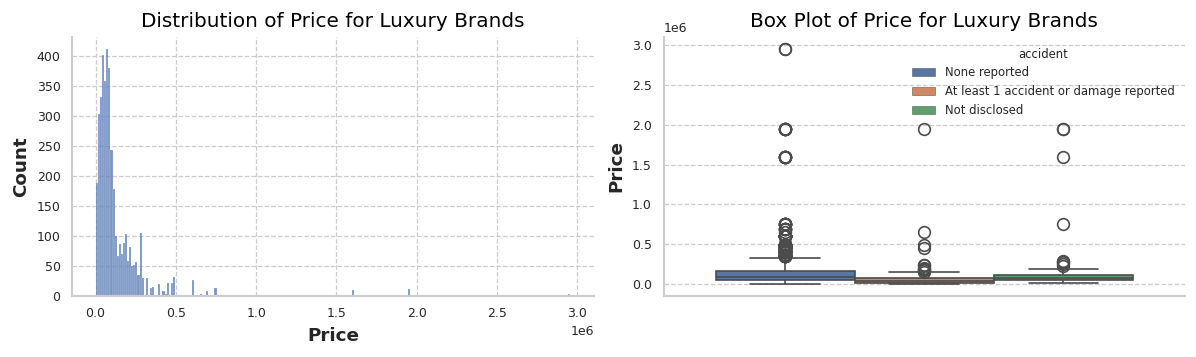

In [ ]:
# Filter data where `luxury_brand` is 1
luxury_brand_df = df_train_ext[df_train_ext['luxury_brand'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(luxury_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Luxury Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=luxury_brand_df['price'], ax=axes[1], hue=luxury_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Luxury Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_train_ext = df_train_ext.drop(df_train_ext[(df_train_ext.accident=="None reported")&(df_train_ext.price<=25_000)&(df_train_ext.luxury_brand==1)].index,axis=0)
df_train_ext.shape

(188193, 33)

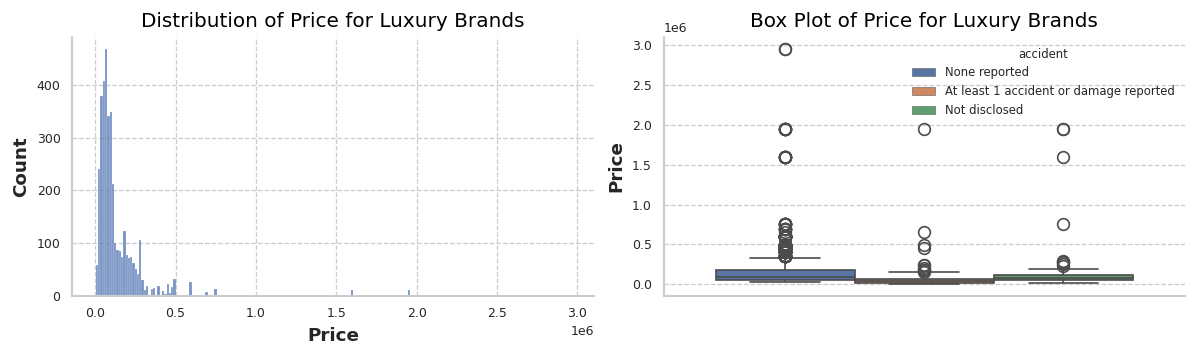

In [ ]:
# Filter data where `luxury_brand` is 1
luxury_brand_df = df_train_ext[df_train_ext['luxury_brand'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(luxury_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Luxury Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=luxury_brand_df['price'], ax=axes[1], hue=luxury_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Luxury Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

#### **PREMIUM BRANDS**

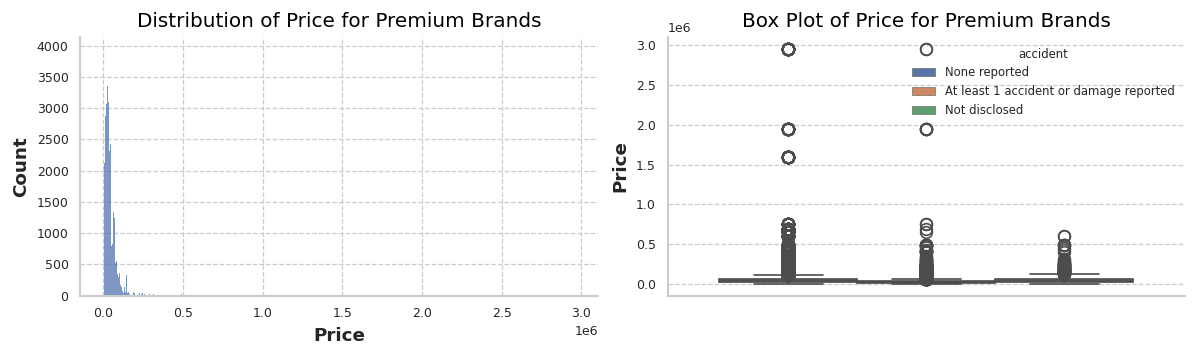

In [ ]:
# Filter data where `premium` is 1
premium_brand_df = df_train_ext[df_train_ext['premium_brand'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(premium_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Premium Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=premium_brand_df['price'], ax=axes[1], hue=premium_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Premium Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
#premium_brand_df[premium_brand_df.price>=600_000].shape

In [ ]:
premium_brand_df[(premium_brand_df.price<=4500)&(premium_brand_df.accident=="None reported")&(premium_brand_df.milage<=11)].shape

(77, 33)

In [ ]:
df_train_ext = df_train_ext.drop(df_train_ext[(df_train_ext.accident=="None reported")&(df_train_ext.price<=4500)&(df_train_ext.premium_brand==1)&(df_train_ext.accident=="None reported")].index,axis=0)
df_train_ext = df_train_ext.drop(df_train_ext[(df_train_ext.price>=550_000)&(df_train_ext.premium_brand==1)].index,axis=0)

df_train_ext.shape

(187237, 33)

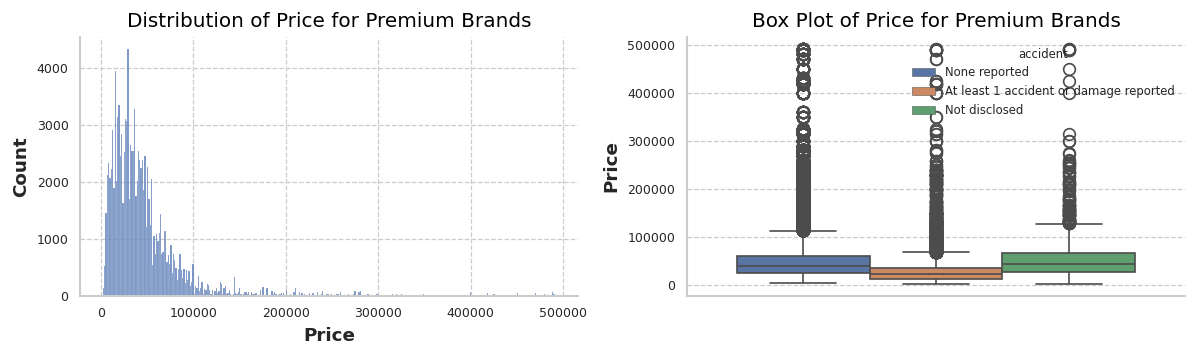

In [ ]:
# Filter data where `premium` is 1
premium_brand_df = df_train_ext[df_train_ext['premium_brand'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(premium_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Premium Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=premium_brand_df['price'], ax=axes[1], hue=premium_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Premium Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
#premium_brand_df.nlargest(10, "price")
#df_train_ext[df_train_ext.brand=="INFINITI"].sort_values("price", ascending=False)

#### **Popular Brands**

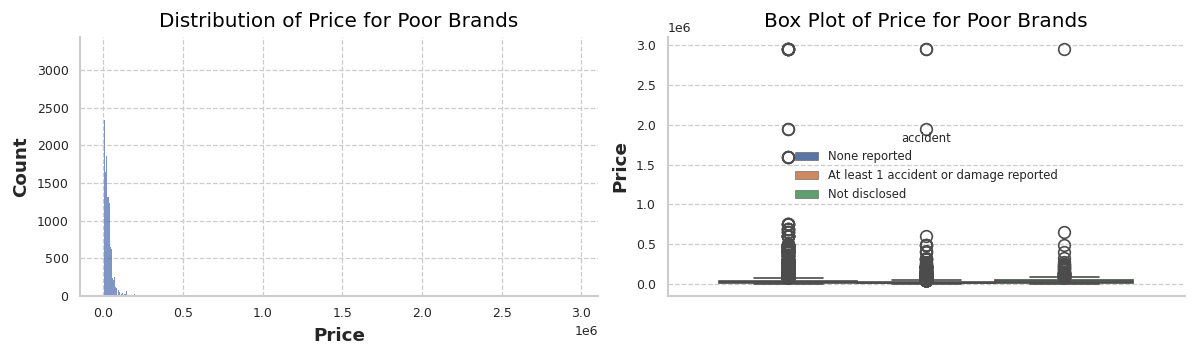

In [ ]:
# Filter data where `premium` is 1
poor_brand_df = df_train_ext[(df_train_ext['premium_brand'] == 0)&(df_train_ext['luxury_brand'] == 0)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(poor_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Poor Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=poor_brand_df['price'], ax=axes[1], hue=poor_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Poor Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
poor_brand_df[poor_brand_df.price>=350_000].sort_values("price", ascending=False).shape

(169, 33)

In [ ]:
print(df_train_ext.shape)
df_train_ext = df_train_ext.drop(df_train_ext[(df_train_ext.price>=250_000)&(df_train_ext['premium_brand'] == 0)&(df_train_ext['luxury_brand'] == 0)].index,axis=0)
#df_train_ext = df_train_ext.drop(df_train_ext[(df_train_ext.price>=750_000)&(df_train_ext['premium_brand'] == 0)&(df_train_ext['luxury_brand'] == 0)].index,axis=0)
print(df_train_ext.shape)

(187237, 33)
(186906, 33)


In [ ]:
df_train_ext.reset_index(drop=True, inplace=True)

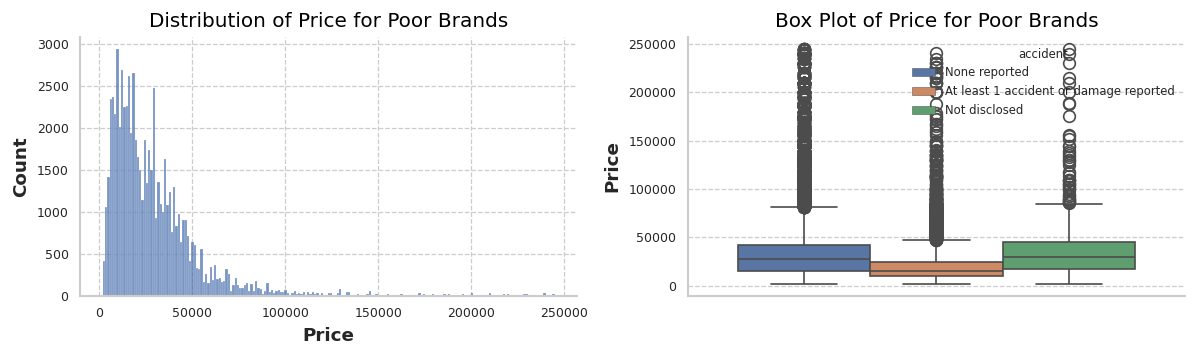

In [ ]:
# Filter data where `premium` is 1
poor_brand_df = df_train_ext[(df_train_ext['premium_brand'] == 0)&(df_train_ext['luxury_brand'] == 0)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram in the first subplot
sns.histplot(poor_brand_df['price'], ax=axes[0], kde=False)
axes[0].set_title('Distribution of Price for Poor Brands')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Boxplot in the second subplot
sns.boxplot(y=poor_brand_df['price'], ax=axes[1], hue=poor_brand_df['accident'])
axes[1].set_title('Box Plot of Price for Poor Brands')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

### Analize Brands Value

In [ ]:
pd.set_option("display.max_rows", None)
df_train_ext[df_train_ext["accident"]=="None reported"].groupby(["brand"])["price"].median().sort_values(ascending=False)

,price
brand,
Bugatti,162950.0
Lamborghini,129000.0
Ferrari,95000.0
McLaren,92000.0
Bentley,90000.0
Rolls-Royce,83998.0
Rivian,82000.0
Aston,77750.0
Maybach,72599.5


In [ ]:
df_train_ext[(df_train_ext["brand"]=="Tesla")&(df_train_ext["fuel_type"]=="Electric")].sample(5)

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,ext_col_nan,Dummy_Nero,Dummy_BLK,Dummy_Special_color,Dummy_Poor_color,Dummy_RED,Dummy_mult,Dummy_grey,Dummy_metal,Dummy_cus,int_col_nan,Dummy_Special_color_int,horsepower,engine_capacity,turbo,num_cylinders,age,milage_per_year,premium_brand,luxury_brand,engine_eff,skew,is_GT
88816,Tesla,Model S Plaid,10.855744,Electric,A/T,Black,Black,None reported,Yes,69500,0,0,0,0,0,0,0,0,0,0,0,0,1020.0,5.70,No Turbo,8,5,10366.000000,1,0,40.80,3.134722,0
16677,Tesla,Model X Long Range,9.770013,Electric,A/T,Black,Black,None reported,Yes,50000,0,0,0,0,0,0,0,0,0,0,0,0,518.0,5.50,No Turbo,8,5,3500.000000,1,0,20.72,6.271736,0
136541,Tesla,Model S 100D,10.839601,Electric,A/T,Black,Beige,None reported,Yes,20900,0,0,0,0,0,0,0,0,0,0,0,0,518.0,4.15,No Turbo,8,9,5666.666667,1,0,20.72,5.578711,0
87249,Tesla,Model S 85D,11.213481,Electric,1-Speed A/T,Grey,Beige,None reported,Yes,33000,0,0,0,0,0,0,0,0,0,0,0,0,422.0,4.15,No Turbo,8,11,6738.363636,1,0,16.88,1.000397,0
107542,Tesla,Model Y Long Range,10.407319,Electric,A/T,White,Black,None reported,Yes,37700,0,0,0,0,0,0,0,0,0,0,0,0,425.0,3.00,No Turbo,8,5,6620.000000,1,0,17.00,6.097560,0


In [ ]:
#df_train_ext.to_csv("train_extended_ext_final_no_outliers.csv", index=False)
#df_test_ext.to_csv("test_extended_ext_final_no_outliers.csv", index=False)

In [ ]:
#df_train_ext= pd.read_csv("train_extended_ext_final_no_outliers.csv")
#df_test_ext = pd.read_csv("test_extended_ext_final_no_outliers.csv")

#df_train_ext= pd.read_csv("train_extended_ext_final_outliers.csv")
#df_test_ext = pd.read_csv("test_extended_ext_final_outliers.csv")
#df_train_ext.head()

## Review: Models

Remove all the models and Brands that are not in the test set:

In [ ]:
to_remove = list(set(df_train_ext.model.unique()) - set(df_test.model.unique()))
print(to_remove)

['Forte LX', 'X5 3.0i', 'X5 eDrive xDrive40e', 'Impreza Premium', 'X5 xDrive 35i Sport Activity', 'i3 Base', 'V60 T6 R-Design Platinum']


In [ ]:
for rem in to_remove:
    index_rem = df_train_ext[df_train_ext.model==rem].index
    df_train_ext = df_train_ext.drop(index_rem, axis=0)

In [ ]:
import category_encoders as ce

In [ ]:
df_train_ext.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186888 entries, 0 to 186905
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   brand                    186888 non-null  object 
 1   model                    186888 non-null  object 
 2   milage                   186888 non-null  float64
 3   fuel_type                186888 non-null  object 
 4   transmission             186888 non-null  object 
 5   ext_col                  186888 non-null  object 
 6   int_col                  186888 non-null  object 
 7   accident                 186888 non-null  object 
 8   clean_title              186888 non-null  object 
 9   price                    186888 non-null  int64  
 10  ext_col_nan              186888 non-null  int64  
 11  Dummy_Nero               186888 non-null  int64  
 12  Dummy_BLK                186888 non-null  int64  
 13  Dummy_Special_color      186888 non-null  int64  
 14  Dummy_Poo

In [ ]:
cat_col = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', "age", "clean_title","turbo", "num_cylinders","accident"]

# Target Encoder for XGBRegressor
train_data_encoded = df_train_ext.copy()
test_data_encoded = df_test_ext.copy()

target_encoder = ce.TargetEncoder(cols=cat_col)
train_data_encoded[cat_col] = target_encoder.fit_transform(train_data_encoded[cat_col], train_data_encoded["price"])
test_data_encoded[cat_col] = target_encoder.transform(test_data_encoded[cat_col])

In [ ]:
# # Compute the correlation matrix
correlation_matrix = train_data_encoded[train_data_encoded.select_dtypes(["float","int"]).columns].corr()
target_correlation = correlation_matrix['price']
print(target_correlation)

brand                      0.357411
model                      0.509841
milage                    -0.457590
fuel_type                  0.093143
transmission               0.251330
ext_col                    0.063304
int_col                    0.160064
accident                   0.188680
clean_title                0.134220
price                      1.000000
ext_col_nan                0.084106
Dummy_Nero                 0.049042
Dummy_BLK                  0.012773
Dummy_Special_color        0.168898
Dummy_Poor_color          -0.012308
Dummy_RED                  0.073132
Dummy_mult                 0.018995
Dummy_grey                 0.034722
Dummy_metal                0.070884
Dummy_cus                  0.086677
int_col_nan                0.006710
Dummy_Special_color_int    0.194041
horsepower                 0.387347
engine_capacity            0.135408
turbo                      0.140258
num_cylinders              0.244901
age                        0.416699
milage_per_year           -0

In [ ]:
#train_data_encoded.select_dtypes("float").columns

In [ ]:
#train_data_encoded.head()

In [ ]:
del train_data_encoded,correlation_matrix
gc.collect()

1007

In [ ]:
#df_train_ext[['accident', 'clean_title',"luxury_brand","premium_brand","turbo"]].describe(include ="all")

In [ ]:
#df_train_ext.head(3)

In [ ]:
#df_test_ext.head(3)

## Tree Models:

### **Hyperparameter Tuning- Optuna**

In [ ]:
#df_train_ext.head()

In [ ]:
# Step 1: Data Preparation
y = df_train_ext['price']
X = df_train_ext.drop(columns=['price'])

use_gpu = True  # Set to False if you want to use CPU

In [ ]:
X[X.select_dtypes(include=['object']).columns]=X[X.select_dtypes(include=['object']).columns].astype("category")
df_test_ext[df_test_ext.select_dtypes(include=['object']).columns]=df_test_ext[df_test_ext.select_dtypes(include=['object']).columns].astype("category")
#X.info();df_test_ext.info()

In [ ]:
#X.info()

In [ ]:
categorical_features = ['brand', 'model']
cat_bin = [ "turbo",'fuel_type', 'transmission', 'ext_col', 'int_col', "age", "clean_title", "num_cylinders","accident"]
#categorical_features_2 = ['clean_title'
tot_cat = categorical_features + cat_bin

In [ ]:
# Step 2: Objective Function for Optuna
def objective(trial, model_class, X, y, use_gpu=False):

    categorical_features = ['brand', 'model']
    cat_bin = [ "turbo",'fuel_type', 'transmission', 'ext_col', 'int_col', "age", "clean_title", "num_cylinders","accident"]
    tot_cat = categorical_features + cat_bin
    numeric_features = [col for col in X.columns if col not in tot_cat]

    if model_class == XGBRegressor:
        params = {
            'n_estimators': 851, #trial.suggest_int('n_estimators', 100, 400, step=1),
            'learning_rate': 0.01, #trial.suggest_loguniform('learning_rate', 0.01, 0.03),
            'max_depth': trial.suggest_int('max_depth', 10, 20),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 30),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.30, 0.90, step=0.025),
            'subsample' :trial.suggest_float('subsample', .30, 0.90, step=0.025),
            'reg_lambda' : trial.suggest_float('reg_lambda', 1e-3, 10.0, log = True),
            'reg_alpha' :  trial.suggest_float('reg_alpha', 1e-3, 10.0, log = True),
            'random_state': 42,
            'tree_method': 'gpu_hist' if use_gpu else 'hist'
        }

        # Create the early stopping callback
        early_stop = EarlyStopping(rounds=61, metric_name="rmse")

        model = model_class(**params, objective='reg:squarederror',callbacks=[early_stop], enable_categorical="True")

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', ce.TargetEncoder(), categorical_features),
                ('cat_bin', OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"), cat_bin),
                ('num', 'passthrough', numeric_features)
            ])


        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('model', model)
        ], verbose=False)

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X, X["brand"]):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipeline[:-1].fit(X_train, y_train)
            X_val_ = pipeline[:-1].transform(X_val) # Transform X_val using the same steps as X
            eval_set = [(X_val_, y_val)]
            fit_params = {'model__eval_set': eval_set}

            # Fit the pipeline with early stopping
            pipeline.fit(X_train, y_train, **fit_params)

            y_pred = pipeline.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        return np.mean(rmse_scores)

    elif model_class == LGBMRegressor:
#{'learning_rate': 0.014924620627674447, 'reg_alpha': 0.2737441785534247, 'reg_lambda': 0.5444882158181196, 'max_depth': 12, 'colsample_bytree': 0.4, 'subsample': 0.9500000000000001}
        params = {
        #'num_leaves':         trial.suggest_int('num_leaves', 100, 111, step=1),
        'n_estimators': 1000, #trial.suggest_int('n_estimators', 250, 800),
        'learning_rate':      0.015, #trial.suggest_loguniform('learning_rate', 0.01, 0.03),
        #'min_child_samples':  trial.suggest_int('min_child_samples', 60, 70, step=1),
        #'min_child_weight' :  trial.suggest_float("min_child_weight", 1e-2, 0.1, log=True),
        "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "max_depth" :         trial.suggest_int('max_depth', 5, 20, step=1),
        #'bagging_freq' :      trial.suggest_int('bagging_freq', 3, 9),
        #'max_bin' :           trial.suggest_int('max_bin', 401, 501, step=5),
        'colsample_bytree':   trial.suggest_float("colsample_bytree", 0.30, 0.95, step=0.05),
        'subsample':          trial.suggest_float("subsample", 0.70, 1.0, step=0.025),
        "learning_rate" :     0.01,
        'random_state':       42,
        'force_col_wise':     True,
        'device':             "cpu"
        }

        #if params["bagging_freq"]>0:
        #    params['bagging_fraction'] =  trial.suggest_float("bagging_fraction", 0.75, 0.85, step=0.01)

        model = model_class(**params, objective='regression')
        # Use CPU to avoid GPU issues
#         if use_gpu:
#             model.set_params(device='cpu')

        pipeline = Pipeline([('model', model)])

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X, X["brand"]):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        return np.mean(rmse_scores)

    elif model_class == CatBoostRegressor:
        params = {
            'loss_function':       'RMSE',
            'eval_metric':         'RMSE',
            'bootstrap_type':      'Bernoulli',
            'iterations':           4000, #: trial.suggest_int('iterations', 500, 4000),
            'learning_rate':         0.015, #: trial.suggest_loguniform('learning_rate', 0.01, 0.03),
            'depth'                 : trial.suggest_int('depth', 10, 16),
            'l2_leaf_reg'           : trial.suggest_float("l2_leaf_reg", 0.1, 10.0, log=True),
            #"bagging_temperature"   : trial.suggest_float('bagging_temperature', 1, 10),
             'subsample'             : trial.suggest_float("subsample", 0.7, 1.0, step=0.025),
            'random_seed': 42,
            'task_type': 'GPU' if use_gpu else 'CPU'
        }

        model = model_class(**params, verbose=0)

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X, X["brand"]):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            train_pool = Pool(X_train, y_train, cat_features=tot_cat)
            val_pool = Pool(X_val, y_val, cat_features=tot_cat)

            model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=200, verbose=0)
            y_pred = model.predict(val_pool)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        return np.mean(rmse_scores)

    elif model_class == PoissonRegressor:

        params = {
            'max_iter':             1000,
            'alpha':                trial.suggest_float("alpha", 0.001, 10.0, log=True),
                  }

        model = model_class(**params)

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', ce.TargetEncoder(), categorical_features),
                ('cat_bin', OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"), cat_bin),
                ('num', 'passthrough', numeric_features)
            ])


        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('model', model)
        ], verbose=False)

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []

        for train_idx, val_idx in kf.split(X, X["brand"]):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Fit the pipeline with early stopping
            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        return np.mean(rmse_scores)


# Step 3: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, use_gpu):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, model_class, X, y, use_gpu=use_gpu), n_trials=n_trials)
    numeric_features = [col for col in X.columns if col not in tot_cat]
    return study  # Return the study object

In [ ]:
# Step 4: Training and Evaluation
def train_and_evaluate(model_class, params, X, y, use_gpu, X_val=None, y_val=None, es=51):
    categorical_features = ['brand', 'model']
    cat_bin = [ "turbo",'fuel_type', 'transmission', 'ext_col', 'int_col', "age", "clean_title", "num_cylinders","accident"]

    tot_cat = categorical_features + cat_bin
    numeric_features = [col for col in X.columns if col not in tot_cat]

    if model_class == XGBRegressor:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', ce.TargetEncoder(), categorical_features),
                ('cat_bin', OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"), cat_bin),
                ('num', 'passthrough', numeric_features)
            ])


        # Create the early stopping callback
        early_stop = EarlyStopping(rounds=es, metric_name="rmse")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('model', model_class(**params, objective='reg:squarederror', tree_method='gpu_hist' if use_gpu else 'auto',
                                  callbacks=[early_stop], enable_categorical="True",verbosity=0))
        ])

        # Prepare your eval_set for early stopping
        pipeline[:-1].fit(X, y)
        X_val_ = pipeline[:-1].transform(X_val) # Transform X_val using the same steps as X
        eval_set = [(X_val_, y_val)]

        # Define the fit parameters with the double underscore notation
        fit_params = {
            'model__eval_set': eval_set
            }

        pipeline.fit(X, y, **fit_params)
        y_pred = pipeline.predict(X)

    elif model_class == LGBMRegressor:
#         # Set to CPU if GPU usage is specified
#         if use_gpu:
#             params['device'] = 'cpu'
        if X_val is None and y_val is None:
          model = model_class(**params, objective='regression', verbose=-1)
          pipeline = Pipeline([('model',model)])
          pipeline.fit(X, y)
          y_pred = pipeline.predict(X)
        else:
          model = model_class(**params, objective='regression', verbose=-1)
          model.fit(X, y, eval_set=(X_val, y_val), callbacks=[early_stopping(stopping_rounds=es)])
          y_pred = model.predict(X)

    elif model_class == CatBoostRegressor:
        train_pool = Pool(X, y, cat_features=tot_cat)
        val_pool = Pool(X_val, y_val, cat_features=tot_cat)

        # Use GPU or CPU based on the flag
        params['task_type'] = 'GPU' if use_gpu else 'CPU'
        params['loss_function']='RMSE'
        params['eval_metric']='RMSE'
        params['bootstrap_type']='Bernoulli'
        params['iterations']=4000
        params['learning_rate']=0.015

        model = model_class(**params, verbose=0)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=es)  # Apply early stopping
        y_pred = model.predict(train_pool)

    elif model_class == PoissonRegressor:
        preprocessor = ColumnTransformer(
                                          transformers=[
                                              ('cat', ce.TargetEncoder(), categorical_features),
                                              ('cat_bin', OneHotEncoder(drop="first",sparse_output=False,
                                                                        handle_unknown="ignore"), cat_bin),
                                              ('num', 'passthrough', numeric_features)
                                          ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('model', model_class(**params))])


        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

    elif model_class == GammaRegressor:
        preprocessor = ColumnTransformer(
                                          transformers=[
                                              ('cat', ce.TargetEncoder(), categorical_features),
                                              ('cat_bin', OneHotEncoder(drop="first",sparse_output=False,
                                                                        handle_unknown="ignore"), cat_bin),
                                              ('num', 'passthrough', numeric_features)
                                          ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('model', model_class(**params))])


        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'RMSE on train data for {model_class.__name__}: {rmse}')

    if model_class == CatBoostRegressor or model_class == LGBMRegressor:
        return model  # Return the trained CatBoost model directly
    else:
        return pipeline  # Return the pipeline for other models

In [ ]:
# Step 5: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

#### XGBoost

In [ ]:
# usage with XGBRegressor
xgb_study = tune_hyperparameters(X, y, XGBRegressor, n_trials=101, use_gpu=use_gpu)
save_results(xgb_study, XGBRegressor, "XGBoost")
xgb_params = xgb_study.best_params  # Extract best parameters
#xgb_model = train_and_evaluate(XGBRegressor, xgb_params, X, y, use_gpu)
#xgb_preds_ = xgb_model.predict(df_test_ext)

* {'max_depth': 29, 'min_child_weight': 5, 'colsample_bytree': 0.825, 'subsample': 0.925, 'reg_lambda': 0.07804926714639399, 'reg_alpha': 0.39224544026611263}. Best is trial 17 with value: 38839.10463443243.

* **{'max_depth': 29, 'min_child_weight': 5, 'colsample_bytree': 0.85, 'subsample': 0.95, 'reg_lambda': 0.12276300120266487, 'reg_alpha': 0.12047181544967944}. Best is trial 25 with value: 38782.7465219681.**

* {'max_depth': 28, 'min_child_weight': 5, 'colsample_bytree': 0.775, 'subsample': 0.9, 'reg_lambda': 0.11712195989066673, 'reg_alpha': 0.8788652828669352} Score: 39050.20411068065

* {'max_depth': 29, 'min_child_weight': 5, 'colsample_bytree': 0.975, 'subsample': 0.825, 'reg_lambda': 0.006339328665482851, 'reg_alpha': 0.0536613112277456}. Best is trial 14 with value: 39050.21201562656.

**INCLUDING OUTLIERS**

- 1 RESULTS:
    - MSE: 73002.22233658335
    - Best hyperparameters: {'max_depth': 11, 'min_child_weight': 20, 'colsample_bytree': 0.5, 'subsample': 0.65, 'reg_lambda': 0.15991951720673386, 'reg_alpha': 0.03897467582642847}

- 2 RESULTS:
  - MSE: 72976.56952626754
  - Best hyperparameters: {'max_depth': 20, 'min_child_weight': 29, 'colsample_bytree': 0.425, 'subsample': 0.325, 'reg_lambda': 0.10853520311330123, 'reg_alpha': 1.8035136371987968}

##### Diagnostic:

In [ ]:
trial = xgb_study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

MSE: 72976.56952626754
Best hyperparameters: {'max_depth': 20, 'min_child_weight': 29, 'colsample_bytree': 0.425, 'subsample': 0.325, 'reg_lambda': 0.10853520311330123, 'reg_alpha': 1.8035136371987968}


In [ ]:
fig = optuna.visualization.plot_optimization_history(xgb_study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(xgb_study)
fig.show()

In [ ]:
del xgb_study, xgb_model
gc.collect()

844

##### Train Model:

In [ ]:
xgb_params = {'n_estimators': 1200, 'learning_rate': 0.01,
              'max_depth': 20, 'min_child_weight': 29,
              'colsample_bytree': 0.425, 'subsample': 0.325,
              'reg_lambda': 0.10853520311330123, 'reg_alpha': 1.8035136371987968}

n_splits=3
n_repeats = 3

test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])
oof_pred_xgb = np.zeros(len(X))

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

rskf.get_n_splits(X, X["brand"])

for i, (train_index, val_index) in enumerate(rskf.split(X, X["brand"])):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb_model = train_and_evaluate(XGBRegressor, xgb_params, X_train, y_train, use_gpu, X_val=X_val, y_val=y_val, es=61)
    xgb_preds = xgb_model.predict(X_val)

    oof_pred_xgb[val_index] = xgb_preds

    rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))
    print(f'RMSE on validation data for XGBoost: {rmse}')

    test_results[i] = xgb_model.predict(df_test_ext)
    valid_scores.loc[i, "Model"] = f"XGBoost_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

In [ ]:
display(valid_scores)
valid_scores.RMSE.mean()

,Model,RMSE
0,XGBoost_0,65180.000117
1,XGBoost_1,68135.514805
2,XGBoost_2,70299.792996
3,XGBoost_3,66353.818713
4,XGBoost_4,67624.098596
5,XGBoost_5,69580.486966
6,XGBoost_6,65946.186156
7,XGBoost_7,61467.614204
8,XGBoost_8,75395.106635


67775.84657625132

In [ ]:
df_xgb_preds = pd.DataFrame(oof_pred_xgb, columns=["oof_xgb"])
df_xgb_preds.to_csv("oof/oof_xgb_preds_v9_outliers.csv", index=False)
df_xgb_preds.head()

,oof_xgb
0,8986.976562
1,10313.164062
2,16545.767578
3,57434.507812
4,95008.828125


##### XGBoost Forecast

In [ ]:
#test_results["all_sample"] = xgb_preds_

test_results["mean"] = test_results.mean(axis=1)
test_results.head(10)

,0,1,2,3,4,5,6,7,8,mean
0,16802.439453,18372.132812,19873.835938,18221.474609,17676.492188,18584.554688,18539.921875,18287.347656,17072.744141,18158.994141
1,76774.445312,84105.875000,79829.609375,86741.562500,79620.531250,77359.906250,76239.648438,85055.843750,83862.125000,81065.500000
2,54011.519531,53770.789062,58819.304688,52043.929688,57349.539062,59482.082031,51097.164062,52573.210938,57247.675781,55155.027344
3,27574.433594,26650.500000,28913.937500,27607.263672,27299.253906,28822.234375,26766.693359,26346.732422,26446.599609,27380.849609
4,29804.462891,28783.585938,29520.304688,29587.695312,28184.419922,29817.947266,30297.773438,28371.298828,28135.812500,29167.035156
5,17339.664062,17771.746094,18398.878906,18771.845703,18403.662109,17333.894531,17941.441406,17479.734375,17415.806641,17872.962891
6,14108.201172,13316.957031,14062.822266,13812.109375,12728.113281,13813.964844,13111.248047,13825.054688,13529.755859,13589.803711
7,35547.683594,33114.601562,35999.812500,37423.328125,37024.757812,35058.660156,34494.871094,36913.433594,35469.578125,35671.859375
8,75371.421875,73255.968750,69029.250000,84455.328125,75583.492188,70765.578125,84430.781250,77552.937500,68904.164062,75483.218750
9,34202.039062,30274.648438,31429.542969,32909.855469,30693.089844,30326.000000,30290.550781,31744.421875,29912.197266,31309.148438


In [ ]:
df_sub["price"] = test_results["mean"]
df_sub.head()

,id,price
0,188533,18158.994141
1,188534,81065.500000
2,188535,55155.027344
3,188536,27380.849609
4,188537,29167.035156


In [ ]:
df_sub.to_csv("submissions/submission_xgb_v9_outliers.csv", index=False)

In [ ]:
# from google.colab import auth
# import google.auth
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaFileUpload

# from email.mime.text import MIMEText
# from email.mime.multipart import MIMEMultipart
# from email.mime.base import MIMEBase
# from email import encoders

# import base64
# import mimetypes

# # 1. Authenticate and get credentials
# auth.authenticate_user()
# creds, _ = google.auth.default()

# # 2. Build the Gmail API service
# service = build('gmail', 'v1', credentials=creds)

# # 3. Compose the email
# email_msg = MIMEMultipart()
# email_msg['to'] = 'fabrizio.basso@invesco.com'
# email_msg['subject'] = 'Car File'
# email_msg.attach(MIMEText('Email body', 'plain'))

# # 4. Attach the file from Google Drive
# #file_id = 'YOUR_FILE_ID_FROM_GOOGLE_DRIVE' # Replace with the actual file ID
# file_name = 'submission_xgb_v8_outliers.csv' # Replace with the actual file name
# mime_type, _ = mimetypes.guess_type(file_name)

# media = MediaFileUpload(f'/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S4E9_Cars/submissions/{file_name}', mimetype=mime_type)
# attachment = MIMEBase('application', 'octet-stream')
# attachment.set_payload(media.getbytes(0, media.size()))
# encoders.encode_base64(attachment)
# attachment.add_header('Content-Disposition', 'attachment', filename=file_name)
# email_msg.attach(attachment)

# # 5. Encode the email
# encoded_message = base64.urlsafe_b64encode(email_msg.as_bytes()).decode()

# # 6. Send the email
# create_message = {'raw': encoded_message}
# send_message = (service.users().messages().send(userId="me", body=create_message).execute())

# print(f'Message Id: {send_message["id"]}')

#### **LGBMRegressor**

In [ ]:
X[X.select_dtypes(include=['object']).columns]=X[X.select_dtypes(include=['object']).columns].astype("category")
df_test_ext[df_test_ext.select_dtypes(include=['object']).columns]=df_test_ext[df_test_ext.select_dtypes(include=['object']).columns].astype("category")
X.info();df_test_ext.info()

In [ ]:
# Usage with LGBMRegressor
lgbm_study = tune_hyperparameters(X, y, LGBMRegressor, n_trials=150, use_gpu=use_gpu)
save_results(lgbm_study, LGBMRegressor, "LightGBM")
lgbm_params = lgbm_study.best_params
lgbm_model = train_and_evaluate(LGBMRegressor, lgbm_params, X, y, use_gpu)
# lgbm_preds = lgbm_model.predict(test_data)

In [ ]:
print(lgbm_params)

{'reg_alpha': 0.46744886322047696, 'reg_lambda': 8.064180196480073, 'max_depth': 5, 'colsample_bytree': 0.3, 'subsample': 0.85}


**New Dataset with Outliers**
* Model 1:
  - RMSE: 68111.35949925394:
  - Param: {'learning_rate': 0.014924620627674447, 'reg_alpha': 0.2737441785534247, 'reg_lambda': 0.5444882158181196, 'max_depth': 12, 'colsample_bytree': 0.4, 'subsample': 0.95}

* Model 2:  
  - RMSE: 67919.2555001917
  - Param: {'reg_alpha': 0.46744886322047696, 'reg_lambda': 8.064180196480073, 'max_depth': 5, 'colsample_bytree': 0.3, 'subsample': 0.85}

##### Diagnostic:

In [ ]:
trial = lgbm_study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

MSE: 67919.2555001917
Best hyperparameters: {'reg_alpha': 0.46744886322047696, 'reg_lambda': 8.064180196480073, 'max_depth': 5, 'colsample_bytree': 0.3, 'subsample': 0.85}


In [ ]:
fig = optuna.visualization.plot_optimization_history(lgbm_study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(lgbm_study)
fig.show()

In [ ]:
del lgbm_study
gc.collect()

##### Train Model:

**NO EARLY STOPPING**

In [ ]:
# lgbm_params = {'n_estimators': 1200,
#               'max_depth': 14,
#               'learning_rate': 0.014,
#                'reg_alpha': 0.2737441785534247,
#                'reg_lambda': 0.5444882158181196,
#                'max_depth': 12,
#                'colsample_bytree': 0.4,
#                'subsample': 0.95,
#                "learning_rate" :     0.01,
#                'random_state':       42,
#                'device':"cpu"}

# n_splits=3
# n_repeats = 3

# test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
# valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])

# rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

# rskf.get_n_splits(X, X["brand"])

# for i, (train_index, val_index) in enumerate(rskf.split(X, y)):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     lgbm_model = train_and_evaluate(LGBMRegressor, lgbm_params, X_train, y_train, use_gpu)
#     lgbm_preds = lgbm_model.predict(X_val)

#     rmse = np.sqrt(mean_squared_error(y_val, lgbm_preds))
#     print(f'RMSE on validation data for LightGBM: {rmse}')

#     test_results[i] = lgbm_model.predict(df_test_ext)
#     valid_scores.loc[i, "Model"] = f"LightGBM_{i}"
#     valid_scores.loc[i, "RMSE"] = rmse

# gc.collect()

RMSE on train data for LGBMRegressor: 61214.33018005848
RMSE on validation data for LightGBM: 68509.16801790065
RMSE on train data for LGBMRegressor: 61533.257108066224
RMSE on validation data for LightGBM: 68320.84790601258
RMSE on train data for LGBMRegressor: 61202.43057148336
RMSE on validation data for LightGBM: 68727.49413412364
RMSE on train data for LGBMRegressor: 61449.004569796045
RMSE on validation data for LightGBM: 68161.41925026095
RMSE on train data for LGBMRegressor: 61732.92963042908
RMSE on validation data for LightGBM: 67945.16630496965
RMSE on train data for LGBMRegressor: 61025.633790696585
RMSE on validation data for LightGBM: 68685.91479869703
RMSE on train data for LGBMRegressor: 61904.927918539106
RMSE on validation data for LightGBM: 68058.91861285502
RMSE on train data for LGBMRegressor: 61883.381997744735
RMSE on validation data for LightGBM: 68149.92340738581
RMSE on train data for LGBMRegressor: 60550.47782641887
RMSE on validation data for LightGBM: 68738

101

**WITH EARLY-STOPPING**

In [ ]:
lgbm_params = {'n_estimators': 1300,
               'learning_rate': 0.014,
               'reg_alpha': 0.46744886322047696,
               'reg_lambda': 8.064180196480073,
               'max_depth': 5,
               'colsample_bytree': 0.3,
               'subsample': 0.85,
               'random_state':       42,
               'device':"cpu"}

n_splits=3
n_repeats = 3

test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])

oof_preds_lgbm = np.zeros(len(X))

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

rskf.get_n_splits(X, X["brand"])

for i, (train_index, val_index) in enumerate(rskf.split(X, X["brand"])):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    lgbm_model = train_and_evaluate(LGBMRegressor, lgbm_params, X_train, y_train, use_gpu, X_val=X_val, y_val=y_val,es=181)
    lgbm_preds = lgbm_model.predict(X_val)

    oof_preds_lgbm[val_index] = lgbm_preds

    rmse = np.sqrt(mean_squared_error(y_val, lgbm_preds))
    print(f'RMSE on validation data for LightGBM: {rmse}')

    test_results[i] = lgbm_model.predict(df_test_ext)
    valid_scores.loc[i, "Model"] = f"LightGBM_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

Training until validation scores don't improve for 181 rounds
Early stopping, best iteration is:
[369]	valid_0's l2: 4.26162e+09
RMSE on train data for LGBMRegressor: 67053.94525515748
RMSE on validation data for LightGBM: 65281.12275970071
Training until validation scores don't improve for 181 rounds
Early stopping, best iteration is:
[366]	valid_0's l2: 4.6539e+09
RMSE on train data for LGBMRegressor: 65776.77329096005
RMSE on validation data for LightGBM: 68219.46697533525
Training until validation scores don't improve for 181 rounds
Early stopping, best iteration is:
[315]	valid_0's l2: 4.95626e+09
RMSE on train data for LGBMRegressor: 64570.07824992683
RMSE on validation data for LightGBM: 70400.6835131141
Training until validation scores don't improve for 181 rounds
Early stopping, best iteration is:
[282]	valid_0's l2: 4.41868e+09
RMSE on train data for LGBMRegressor: 66985.58424433341
RMSE on validation data for LightGBM: 66473.18595647479
Training until validation scores don't

4044

In [ ]:
valid_scores.RMSE.mean()

67877.03994254144

In [ ]:
valid_scores.RMSE.mean()

67953.69317523258

In [ ]:
df_lgbm_preds = pd.DataFrame(oof_preds_lgbm, columns=["oof_lgbm"])
df_lgbm_preds.to_csv("oof/oof_lgbm_preds_v5_with_outliers.csv", index=False)
df_lgbm_preds.head()

,oof_lgbm
0,10107.358139
1,11837.023383
2,16223.246454
3,59227.473920
4,90369.580269


##### LGBM Forecast

In [ ]:
test_results["mean"] = test_results.iloc[:,:-1].mean(axis=1)
test_results.head(10)

,0,1,2,3,4,5,6,7,8,mean
0,18394.387257,18283.728278,18803.626937,19672.126765,18162.692587,18408.647594,18301.363996,18265.357871,19290.450768,18536.491411
1,76470.212641,72837.517863,76225.894003,75797.518504,75127.315177,76677.921637,76230.610675,78147.920314,72167.101846,75939.363852
2,58650.129617,59275.487981,58106.207570,58653.384716,57226.901308,58839.619079,58600.347211,61048.550242,56459.199260,58800.078465
3,26208.155282,26338.089108,26731.393982,27047.073946,25099.860851,26471.978045,26087.217402,25939.761394,27626.314429,26240.441251
4,29534.757114,29391.222412,29809.572452,29071.163040,29654.150899,30199.528003,29767.428090,29270.519395,30114.017405,29587.292675
5,19117.261660,18828.775945,18242.288291,20520.501116,18381.271014,19039.664160,18360.680783,19892.303931,20609.734629,19047.843363
6,16010.184971,16398.323565,15485.475311,17544.304105,15316.456296,15118.679293,15193.635486,16153.668856,16981.584894,15902.590985
7,35648.270568,35681.449191,37733.384532,35598.748682,36461.309937,37642.793201,36077.966655,35613.902765,36286.461283,36307.228192
8,89824.992892,83268.839351,80880.509438,80288.841369,81273.978366,82686.047099,84496.159798,89622.715610,77296.870740,84042.760490
9,33708.954249,33431.975298,33354.351162,34121.392273,33360.462277,33300.885951,33278.887228,32980.340934,34593.978137,33442.156172


In [ ]:
df_sub["price"] = test_results["mean"]
df_sub.head()

,id,price
0,188533,18536.491411
1,188534,75939.363852
2,188535,58800.078465
3,188536,26240.441251
4,188537,29587.292675


In [ ]:
df_sub.to_csv("submissions/submission_lgbm_v5_with_outliers.csv", index=False)

#### **Catboost**

In [ ]:
X[X.select_dtypes(include=['object']).columns]=X[X.select_dtypes(include=['object']).columns].astype("category")
df_test_ext[df_test_ext.select_dtypes(include=['object']).columns]=df_test_ext[df_test_ext.select_dtypes(include=['object']).columns].astype("category")
#X.info();df_test_ext.info()

In [ ]:
# # Usage with CatBoostRegressor
#catboost_study = tune_hyperparameters(X, y, CatBoostRegressor, n_trials=25, use_gpu=use_gpu)
#save_results(catboost_study, CatBoostRegressor, "CatBoost")
#catboost_params = catboost_study.best_params
catboost_model = train_and_evaluate(CatBoostRegressor, catboost_params, X, y, use_gpu)
#catboost_preds = catboost_model.predict(test_data)

parameters: {'learning_rate': 0.014921267420169311, 'depth': 13, 'l2_leaf_reg': 3.3634869818677156, 'subsample': 0.925}. Best is trial 23 with value: 39447.7526085777.

##### Diagnostic:

In [ ]:
trial = catboost_study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

MSE: 39463.95462347853
Best hyperparameters: {'depth': 12, 'l2_leaf_reg': 6.440593750215689, 'subsample': 0.8999999999999999}


In [ ]:
fig = optuna.visualization.plot_optimization_history(catboost_study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(catboost_study)
fig.show()

In [ ]:
del catboost_study, catboost_model
gc.collect()

##### Train Model:

In [ ]:
cat_params = {'learning_rate': 0.014921267420169311, 'depth': 13, 'l2_leaf_reg': 3.3634869818677156, 'subsample': 0.925}

n_splits=3
n_repeats = 3

test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])

oof_preds_cat = np.zeros(len(X))

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

rskf.get_n_splits(X, X["brand"])

for i, (train_index, val_index) in enumerate(rskf.split(X, X["brand"])):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    cat_model = train_and_evaluate(CatBoostRegressor, cat_params, X_train, y_train, use_gpu, X_val=X_val, y_val=y_val)
    cat_preds = cat_model.predict(X_val)

    oof_preds_cat[val_index] = cat_preds

    rmse = np.sqrt(mean_squared_error(y_val, cat_preds))
    print(f'RMSE on validation data for cat: {rmse}')

    test_results[i] = cat_model.predict(df_test_ext)
    valid_scores.loc[i, "Model"] = f"cat_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

In [ ]:
df_cat_preds = pd.DataFrame(oof_preds_cat, columns=["oof_cat"])
df_cat_preds.to_csv("oof/oof_cat_preds_v1.csv", index=False)
df_cat_preds.head()

,oof_cat
0,9849.838286
1,9890.994642
2,14011.991253
3,65829.441947
4,65717.279475


In [ ]:
valid_scores

,Model,RMSE
0,cat_0,38890.240694
1,cat_1,38397.88216
2,cat_2,41389.046955
3,cat_3,41233.608735
4,cat_4,39228.522618
5,cat_5,38241.23822
6,cat_6,38449.539483
7,cat_7,38971.46398
8,cat_8,41384.455325


##### CatBoost Forecast

In [ ]:
test_results["mean"] = test_results.mean(axis=1)
test_results.head(10)

,0,1,2,3,4,5,6,7,8,mean
0,18301.918336,17793.233566,18087.287154,19304.739358,17386.299910,18152.360418,18489.581845,18225.786380,18295.994273,18226.355693
1,75007.388358,75101.332767,73847.516144,69489.647012,73602.594838,71505.957861,74174.305079,72727.959888,71299.969497,72972.963494
2,58583.459378,58266.085706,58260.327040,59444.414677,59587.612873,57894.502955,59063.969357,57620.176075,58468.888016,58576.604009
3,25007.943737,24003.375326,25144.861639,24486.242340,23673.816378,23318.175453,23254.946017,24338.203515,25928.679103,24350.693723
4,30436.666139,28920.223466,29343.336769,29394.937132,29778.986463,29129.879565,29728.688730,29538.940817,29828.278254,29566.659704
5,16384.301288,17282.402563,16990.021169,17290.980131,16024.870477,16724.651738,17466.716021,16950.635338,16359.443242,16830.446885
6,14144.500171,13202.819280,13698.185785,13485.469356,13490.651443,13275.823239,14398.538569,13811.329578,13700.741490,13689.784323
7,39458.185100,38023.859398,39102.931685,39508.832096,38274.937457,38403.241288,38545.968869,39493.254437,39032.053793,38871.473791
8,79340.368797,79149.874496,82886.764001,79103.286830,80305.657163,81149.674648,82552.784175,82616.256583,79075.906059,80686.730306
9,32188.030487,32868.902380,33791.378692,32862.600315,32496.937839,33049.952432,33681.093909,32901.550737,32164.500965,32889.438640


In [ ]:
df_sub["price"] = test_results["mean"]
df_sub.head()

,id,price
0,188533,18226.355693
1,188534,72972.963494
2,188535,58576.604009
3,188536,24350.693723
4,188537,29566.659704


In [ ]:
df_sub.to_csv("submissions/submission_cat_v1.csv", index=False)

#### Poisson Regression:

In [ ]:
from sklearn.linear_model import PoissonRegressor, GammaRegressor

In [ ]:
use_gpu=False
# usage with PoissonRegressor
poi_study = tune_hyperparameters(X, y, PoissonRegressor, n_trials=51, use_gpu=use_gpu)
save_results(poi_study, PoissonRegressor, "Poi")
poi_params = poi_study.best_params  # Extract best parameters
#xgb_model = train_and_evaluate(XGBRegressor, xgb_params, X, y, use_gpu)
#xgb_preds_ = xgb_model.predict(df_test_ext)

[I 2024-09-17 21:53:31,787] A new study created in memory with name: no-name-2e80e3f9-ac37-46e0-b658-5f14ba4c7c1e
[I 2024-09-17 21:57:04,698] Trial 0 finished with value: 40567.07367621066 and parameters: {'alpha': 0.004092868226970361}. Best is trial 0 with value: 40567.07367621066.
[I 2024-09-17 22:00:35,576] Trial 1 finished with value: 40567.192171910356 and parameters: {'alpha': 0.08300890115181231}. Best is trial 0 with value: 40567.07367621066.
[I 2024-09-17 22:03:42,783] Trial 2 finished with value: 40573.706071399916 and parameters: {'alpha': 0.7981747269683561}. Best is trial 0 with value: 40567.07367621066.
[I 2024-09-17 22:07:17,208] Trial 3 finished with value: 40567.07208226515 and parameters: {'alpha': 0.011115761335552587}. Best is trial 3 with value: 40567.07208226515.
[I 2024-09-17 22:10:44,161] Trial 4 finished with value: 40567.65631709542 and parameters: {'alpha': 0.18223258429335615}. Best is trial 3 with value: 40567.07208226515.
[I 2024-09-17 22:14:17,834] Trial

KeyboardInterrupt: 

##### Train Model:

In [ ]:
poi_params = {'alpha': 1.0}

n_splits=3
n_repeats = 3

test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])

oof_preds_poi = np.zeros(len(X))

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

rskf.get_n_splits(X, X["brand"])

for i, (train_index, val_index) in enumerate(rskf.split(X, X["brand"])):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    poi_model = train_and_evaluate(PoissonRegressor, poi_params, X_train, y_train, use_gpu, X_val=X_val, y_val=y_val)
    poi_preds = poi_model.predict(X_val)

    oof_preds_poi[val_index] = poi_preds

    rmse = np.sqrt(mean_squared_error(y_val, poi_preds))
    print(f'RMSE on validation data for cat: {rmse}')

    test_results[i] = poi_model.predict(df_test_ext)
    valid_scores.loc[i, "Model"] = f"poi_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

RMSE on train data for PoissonRegressor: 40725.04244024968
RMSE on validation data for cat: 40021.55367038657
RMSE on train data for PoissonRegressor: 41021.08798149199
RMSE on validation data for cat: 39304.82784664579
RMSE on train data for PoissonRegressor: 39411.16197168792
RMSE on validation data for cat: 42683.95209695155
RMSE on train data for PoissonRegressor: 39565.44006263826
RMSE on validation data for cat: 42512.85514040069
RMSE on train data for PoissonRegressor: 40530.59248258999
RMSE on validation data for cat: 40225.8268899468
RMSE on train data for PoissonRegressor: 41037.115656276015
RMSE on validation data for cat: 39420.431011582165
RMSE on train data for PoissonRegressor: 41055.752414909
RMSE on validation data for cat: 39564.85429680941
RMSE on train data for PoissonRegressor: 40671.00938238951
RMSE on validation data for cat: 40069.722568804136
RMSE on train data for PoissonRegressor: 39413.40812351554
RMSE on validation data for cat: 42470.1444630399


36910

    RMSE on train data for PoissonRegressor: 40718.68957618613
    RMSE on validation data for cat: 40010.07675057371
    RMSE on train data for PoissonRegressor: 41015.09513266724
    RMSE on validation data for cat: 39301.15707337416
    RMSE on train data for PoissonRegressor: 39417.75920686562
    RMSE on validation data for cat: 42690.84899097667
    RMSE on train data for PoissonRegressor: 39562.80731892349
    RMSE on validation data for cat: 42509.839722038436
    RMSE on train data for PoissonRegressor: 40548.4530053571
    RMSE on validation data for cat: 40253.386610255606
    RMSE on train data for PoissonRegressor: 41045.61060024812
    RMSE on validation data for cat: 39442.72515985904
    RMSE on train data for PoissonRegressor: 41043.71165100683
    RMSE on validation data for cat: 39555.77869769673
    RMSE on train data for PoissonRegressor: 40671.30648408839
    RMSE on validation data for cat: 40064.129487068865
    RMSE on train data for PoissonRegressor: 39409.70186814949
    RMSE on validation data for cat: 42471.25457782956

In [ ]:
df_poi_preds = pd.DataFrame(oof_preds_poi, columns=["oof_poi"])
df_poi_preds.to_csv("oof/oof_poi_preds_v1.csv", index=False)
df_poi_preds.head()

,oof_poi
0,10125.584346
1,14161.719880
2,16337.453656
3,53782.598832
4,64252.550582


In [ ]:
valid_scores

,Model,RMSE
0,poi_0,40010.076751
1,poi_1,39301.157073
2,poi_2,42690.848991
3,poi_3,42509.839722
4,poi_4,40253.38661
5,poi_5,39442.72516
6,poi_6,39555.778698
7,poi_7,40064.129487
8,poi_8,42471.254578


##### PoissonRegressor Forecast

In [ ]:
test_results["mean"] = test_results.mean(axis=1)
test_results.head(10)

In [ ]:
df_sub["price"] = test_results["mean"]
df_sub.head()

,id,price
0,188533,22346.111759
1,188534,74970.833092
2,188535,56863.110485
3,188536,26571.412760
4,188537,29914.784234


In [ ]:
df_sub.to_csv("submissions/submission_poi_v1.csv", index=False)

### Gamma Regressor:

##### Train Model:

In [ ]:
gam_params = {'alpha': 0.01}

n_splits=3
n_repeats = 3

test_results = pd.DataFrame(columns=list(range(n_splits*n_repeats)))
valid_scores = pd.DataFrame(index= list(range(n_splits*n_repeats)),columns=["Model","RMSE"])

oof_preds_gam = pd.DataFrame(index = list(range(len(X))), columns=["oof_gam"])

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,random_state=36851234)

rskf.get_n_splits(X, X["brand"])

for i, (train_index, val_index) in enumerate(rskf.split(X, X["brand"])):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    gam_model = train_and_evaluate(GammaRegressor, gam_params, X_train, y_train, use_gpu, X_val=X_val, y_val=y_val)
    gam_preds = gam_model.predict(X_val)

    oof_preds_gam.loc[val_index,"oof_gam"] = gam_preds

    rmse = np.sqrt(mean_squared_error(y_val, gam_preds))
    print(f'RMSE on validation data for GammaReg: {rmse}')

    test_results[i] = gam_model.predict(df_test_ext)
    valid_scores.loc[i, "Model"] = f"poi_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

RMSE on train data for GammaRegressor: 40939.978914859035
RMSE on validation data for GammaReg: 40130.171730996895
RMSE on train data for GammaRegressor: 41282.71528451456
RMSE on validation data for GammaReg: 39499.130406124954
RMSE on train data for GammaRegressor: 39690.74413850397
RMSE on validation data for GammaReg: 42763.62799274549
RMSE on train data for GammaRegressor: 39822.20435841112
RMSE on validation data for GammaReg: 42596.11867559037
RMSE on train data for GammaRegressor: 40838.69995448054
RMSE on validation data for GammaReg: 40356.19722769737
RMSE on train data for GammaRegressor: 41278.83080390125
RMSE on validation data for GammaReg: 39535.07067058073
RMSE on train data for GammaRegressor: 41296.12037685115
RMSE on validation data for GammaReg: 39672.88793974205
RMSE on train data for GammaRegressor: 40978.74268775436
RMSE on validation data for GammaReg: 40154.857079315385
RMSE on train data for GammaRegressor: 39657.42355025011
RMSE on validation data for GammaRe

282

In [ ]:
oof_preds_gam.head()

,oof_gam
0,9928.40496
1,15230.179144
2,19558.230009
3,52544.656092
4,56908.831713


In [ ]:
df_gam_preds = oof_preds_gam.copy()
df_gam_preds.to_csv("oof/oof_gam_preds_v1.csv", index=False)
df_gam_preds.head()

,oof_gam
0,9928.40496
1,15230.179144
2,19558.230009
3,52544.656092
4,56908.831713


In [ ]:
valid_scores

,Model,RMSE
0,poi_0,40130.171731
1,poi_1,39499.130406
2,poi_2,42763.627993
3,poi_3,42596.118676
4,poi_4,40356.197228
5,poi_5,39535.070671
6,poi_6,39672.88794
7,poi_7,40154.857079
8,poi_8,42636.508334


##### GammaRegressor Forecast

In [ ]:
test_results["mean"] = test_results.mean(axis=1)
test_results.head(10)

,0,1,2,3,4,5,6,7,8,mean
0,20826.424943,21007.887763,20358.135904,20865.025752,20891.770213,20498.242647,20796.988583,20618.279289,20876.881352,20748.848494
1,74953.686132,78543.913520,74297.312690,74792.097448,75872.525473,76285.583730,75704.015812,74608.229971,76387.316768,75716.075727
2,64154.769061,64388.705286,64284.221929,65246.430732,64481.915031,63495.246355,64769.354159,64467.479412,64014.050619,64366.908065
3,23195.713237,22988.216097,23622.533264,23315.698104,23516.178505,23014.460019,22829.335636,23514.473563,23514.524495,23279.014769
4,26889.688624,26659.602944,26935.487847,27003.633681,27073.977294,26587.059421,26981.374553,26974.904788,26705.134010,26867.873685
5,22077.157729,22210.291981,22793.366824,22468.946677,22435.886727,22365.706549,22529.420880,22502.409073,22247.755004,22403.437938
6,16630.493233,16690.747066,16493.543135,16849.058589,16601.951111,16439.404727,16700.986580,16728.954966,16430.367323,16618.389637
7,37428.474383,37420.546486,37856.696940,38188.241765,37680.392767,37343.128808,37862.261984,37682.948208,37610.934462,37674.847311
8,61946.244656,61556.962347,63352.488635,62578.646256,63424.706189,61539.344549,62879.304190,62612.238777,61899.560923,62421.055169
9,35813.617964,37279.731704,37726.310864,37064.995984,36937.375790,37185.495192,37583.805326,36778.198617,36794.017468,37018.172101


In [ ]:
df_sub["price"] = test_results["mean"]
df_sub.head()

,id,price
0,188533,20748.848494
1,188534,75716.075727
2,188535,64366.908065
3,188536,23279.014769
4,188537,26867.873685


In [ ]:
df_sub.to_csv("submissions/submission_gam_v1.csv", index=False)

### Compare Results

In [ ]:
cat_sub = pd.read_csv("submissions/submission_cat_v1.csv")
lgb_sub = pd.read_csv("submissions/submission_lgbm_v2.csv")
xgb_sub = pd.read_csv("submissions/submission_xgb_v7.csv")
poi_sub = pd.read_csv("submissions/submission_poi_v0.csv")
gam_sub = pd.read_csv("submissions/submission_gam_v1.csv")
xgb_sub_out = pd.read_csv("submissions/submission_xgb_v8_outliers.csv")

all_sub = pd.DataFrame()
all_sub["cat"] = cat_sub["price"]
all_sub["lgb"] = lgb_sub["price"]
all_sub["xgb"] = xgb_sub["price"]
all_sub["xgb_out"] = xgb_sub_out["price"]
all_sub["poi"] = poi_sub["price"]
all_sub["gam"] = gam_sub["price"]

all_sub["mean"] = all_sub.mean(axis=1)
all_sub.head()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True,sharex=True)
axs = np.ravel(axs)


axs[0].scatter(lgb_sub["price"],cat_sub["price"],alpha=0.5, color="firebrick")
axs[0].set_title("LightGBM vs CatBoost")
axs[1].scatter(lgb_sub["price"],xgb_sub["price"],alpha=0.5,color="darkslateblue")
axs[1].set_title("LightGBM vs XGBoost")
axs[2].scatter(lgb_sub["price"],poi_sub["price"],alpha=0.5,color="salmon")
axs[2].set_title("LightGBM vs Poisson")
axs[3].scatter(poi_sub["price"],gam_sub["price"],alpha=0.5,color="royalblue")
axs[3].set_title("LightGBM vs Gamma")

#plt.legend()
axs[0].set_xlabel("LightGBM")
axs[0].set_ylabel("CatBoost")


plt.tight_layout()
plt.show()

In [ ]:
df_sub["price"] = all_sub["mean"]
df_sub.head()

,id,price
0,188533,20304.253556
1,188534,75444.844816
2,188535,57636.904395
3,188536,25847.546074
4,188537,29106.623285


In [ ]:
df_sub.to_csv("submissions/submission_simplemean_v2.csv", index=False)

## VotingRegressor

In [ ]:
y.isna().sum()#.shape

0

In [ ]:
cat_oof = pd.read_csv("oof/oof_cat_preds_v1.csv")
lgb_oof = pd.read_csv("oof/oof_lgbm_preds_v3.csv")
xgb_oof = pd.read_csv("oof/oof_xgb_preds_v7.csv")
poi_oof = pd.read_csv("oof/oof_poi_preds_v0.csv")
gam_oof = pd.read_csv("oof/oof_gam_preds_v1.csv")

all_oof = pd.DataFrame()
all_oof["cat"] = cat_oof["oof_cat"]
all_oof["lgb"] = lgb_oof["oof_lgbm"]
all_oof["xgb"] = xgb_oof["oof_xgb"]
all_oof["poi"] = poi_oof["oof_poi"]
all_oof["gam"] = gam_oof["oof_gam"]

print(all_oof.shape)

(186888, 5)


In [ ]:
all_oof["price"] = y.values
all_oof.isna().sum()

,0
cat,0
lgb,0
xgb,0
poi,0
gam,0
price,0


In [ ]:
all_oof.corr()

,cat,lgb,xgb,poi,gam,price
cat,1.000000,0.976139,0.917369,0.935835,0.933497,0.581095
lgb,0.976139,1.000000,0.928284,0.935145,0.924158,0.578936
xgb,0.917369,0.928284,1.000000,0.867137,0.854573,0.554671
poi,0.935835,0.935145,0.867137,1.000000,0.980949,0.549873
gam,0.933497,0.924158,0.854573,0.980949,1.000000,0.544756
price,0.581095,0.578936,0.554671,0.549873,0.544756,1.000000


In [ ]:
plt.scatter(all_oof["xgb"],all_oof["price"])
plt.xlabel("gam")
plt.ylabel("Target")
plt.title("LightGBM vs Target")
plt.show()

In [ ]:
def rf_objective(trial):
    params = {
              'n_estimators' :      trial.suggest_int('n_estimators', 100, 400, step=5),
              'max_depth' :         trial.suggest_int('max_depth', 4, 12, step=1),
              'min_samples_split' : trial.suggest_int('min_samples_split', 2, 20, step=2),
              'max_features':       trial.suggest_float('max_features', .50, 1.0, step=0.25),
              'max_samples':        trial.suggest_float('max_samples', .30, 1.0, step=0.05),
              }


    optuna_model = RandomForestRegressor(**params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(all_oof.drop(columns=["price"]), all_oof["price"]):
        X_train, X_val = all_oof.drop(columns=["price"]).iloc[train_idx], all_oof.drop(columns=["price"]).iloc[val_idx]
        y_train, y_val = all_oof[["price"]].iloc[train_idx], all_oof[["price"]].iloc[val_idx]

        optuna_model.fit(X_train, y_train)
        y_pred = optuna_model.predict(X_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

    return np.mean(rmse_scores)

In [ ]:
rf_study = optuna.create_study(direction = 'minimize', study_name="rf_opt",
                                sampler = optuna.samplers.TPESampler(seed=42),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
                                )

[I 2024-09-19 09:30:21,695] A new study created in memory with name: rf_opt


In [ ]:
rf_study.optimize(rf_objective, 31, show_progress_bar=True)

##### Train Model:

In [ ]:
rf_params = {'n_estimators': 315, 'max_depth': 5, 'min_samples_split': 12, 'max_features': 0.5, 'max_samples': 0.35}
all_sub_ = all_sub.drop("mean", axis=1)
n_splits=5

test_results = pd.DataFrame(columns=list(range(n_splits)))
valid_scores = pd.DataFrame(index= list(range(n_splits)),columns=["Model","RMSE"])

oof_preds_rf = np.zeros(len(X))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(all_oof.drop(columns=["price"]), all_oof["price"])):
    X_train, X_val = all_oof.drop(columns=["price"]).iloc[train_idx], all_oof.drop(columns=["price"]).iloc[val_idx]
    y_train, y_val = all_oof[["price"]].iloc[train_idx], all_oof[["price"]].iloc[val_idx]

    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_val)

    oof_preds_rf[val_idx] = rf_preds

    rmse = np.sqrt(mean_squared_error(y_val, rf_preds))
    print(f'RMSE on validation data for Ens: {rmse}')

    test_results[i] = rf_model.predict(all_sub_)
    valid_scores.loc[i, "Model"] = f"rf_{i}"
    valid_scores.loc[i, "RMSE"] = rmse

gc.collect()

RMSE on validation data for cat: 38070.9327924113
RMSE on validation data for cat: 36833.86942328785
RMSE on validation data for cat: 39644.124755062796
RMSE on validation data for cat: 43916.84202939313
RMSE on validation data for cat: 38793.69541170168


354854

In [ ]:
test_results["mean"] = test_results.mean(axis=1)
test_results.head(10)

In [ ]:
df_sub["price"] = test_results["mean"]

df_sub.to_csv("submissions/submission_ensemble_v0.csv", index=False)

In [ ]:
df_sub.head()

### Neural Networks:

In [ ]:
df_train_ext.head()

In [ ]:
df_train_ext.describe(include ="all").T

In [ ]:
X = df_train_ext.drop("price", axis=1)
y = df_train_ext["price"]

In [ ]:
from sklearn.preprocessing import FunctionTransformer

categorical_features = ['brand', 'model', 'transmission', "num_cylinders","age"]
cat_bin = [ "turbo",'fuel_type', 'ext_col', 'int_col', "clean_title","accident"]
log_col = ["milage_per_year","engine_eff"]
rev_log_col = ["milage"]

tot_cat = categorical_features + cat_bin + log_col + rev_log_col
numeric_features = [col for col in X.columns if col not in tot_cat]

log_transformer = FunctionTransformer(np.log1p)
neg_log_transformer = FunctionTransformer(lambda x: -np.log1p(x))

preprocessor = ColumnTransformer(
                                  transformers=[
                                      ('cat', ce.james_stein.JamesSteinEncoder(), categorical_features),
                                      ('cat_bin', ce.ordinal.OrdinalEncoder(), cat_bin),
                                      ('log', log_transformer, log_col),
                                      ('neglog', neg_log_transformer, rev_log_col),
                                      ('num', 'passthrough', numeric_features)]
                                  )

In [ ]:
new_X = pd.DataFrame(preprocessor.fit_transform(X,y), columns=tot_cat+numeric_features)
new_X_test = pd.DataFrame(preprocessor.transform(df_test_ext), columns=tot_cat+numeric_features)

In [ ]:
new_X.head()
new_X.shape

(186888, 18)

In [ ]:
new_X.describe(include ="all").T

In [ ]:
cols = list(new_X.columns)

fig, axs = plt.subplots(3, 6, figsize=(15, 6))
axs = np.ravel(axs)

for i, col in enumerate(cols):
    sns.histplot(new_X[col], ax=axs[i], )
    axs[i].set_title(col, fontsize=9)

plt.tight_layout()
plt.show()